In [ ]:
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data.dataset import random_split
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import time
import torch.nn.functional as F

In [ ]:
#load the data as tensor
cifar10 = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())

# Define the CIFAR10 class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Files already downloaded and verified


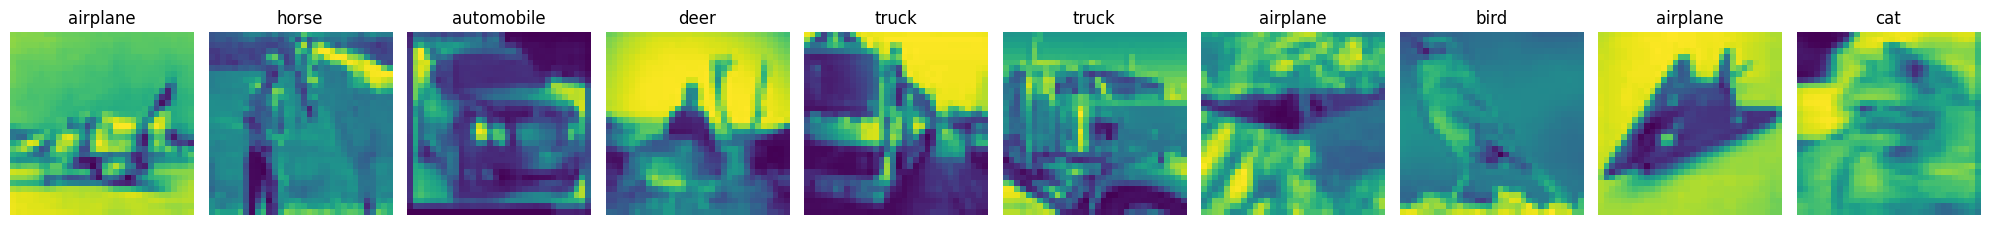

In [ ]:
# Randomly choose 10 images from the dataset
indices = np.random.choice(range(len(cifar10)), 10, replace=False)
random_images = [cifar10[i][0] for i in indices]
random_labels = [cifar10[i][1] for i in indices]

# Plot the images with their labels
plt.figure(figsize=(20, 4))
for idx, (image, label) in enumerate(zip(random_images, random_labels)):
    plt.subplot(1, 10, idx + 1)
    image = image.permute(1, 2, 0) # Convert the image from [C, H, W] to [H, W, C]
    plt.imshow(image)
    plt.title(class_names[label])
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Splitting the data with random_state = 1
lengths = [int(len(cifar10)*0.8), int(len(cifar10)*0.2)]
train_dataset, valid_dataset = random_split(cifar10, lengths, generator=torch.Generator().manual_seed(1))

# Data normalization
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=True)

In [ ]:
#for training of any model
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0.0
    corrects = 0.0
    for batch in train_loader:
        data, target = batch
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.size(0)
        _, preds = torch.max(outputs, 1)
        corrects += torch.sum(preds == target.data)
    return total_loss / len(train_loader.dataset), corrects.double() / len(train_loader.dataset)


In [ ]:
#for validation dataset
def validate(model, valid_loader, criterion, device):
    model.eval()
    total_loss = 0.0
    corrects = 0.0
    with torch.no_grad():
        for batch in valid_loader:
            data, target = batch
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            total_loss += loss.item() * data.size(0)
            _, preds = torch.max(outputs, 1)
            corrects += torch.sum(preds == target.data)
    return total_loss / len(valid_loader.dataset), corrects.double() / len(valid_loader.dataset)


In [ ]:
#Benchmark Model
#Singal layer fully connected
class BenchmarkModel(nn.Module):
    def __init__(self):
        super(BenchmarkModel, self).__init__()
        self.fc = nn.Linear(32*32*3, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = BenchmarkModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.03)


In [ ]:
# Lists to collect losses and accuracies for each epoch
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []

total_epochs = 0
total_time = 0

Epoch 1, Train Loss: 2.5589, Train Accuracy: 0.2475, Validation Loss: 2.9051, Validation Accuracy: 0.2693
Epoch 2, Train Loss: 2.3280, Train Accuracy: 0.2924, Validation Loss: 2.1820, Validation Accuracy: 0.2913
Epoch 3, Train Loss: 2.2448, Train Accuracy: 0.3099, Validation Loss: 2.6698, Validation Accuracy: 0.2548
Epoch 4, Train Loss: 2.2542, Train Accuracy: 0.3122, Validation Loss: 2.1168, Validation Accuracy: 0.3139
Epoch 5, Train Loss: 2.1872, Train Accuracy: 0.3221, Validation Loss: 2.1247, Validation Accuracy: 0.3114
Epoch 6, Train Loss: 2.1912, Train Accuracy: 0.3237, Validation Loss: 2.3976, Validation Accuracy: 0.3505
Epoch 7, Train Loss: 2.1889, Train Accuracy: 0.3276, Validation Loss: 2.1977, Validation Accuracy: 0.2974
Epoch 8, Train Loss: 2.2205, Train Accuracy: 0.3282, Validation Loss: 2.5713, Validation Accuracy: 0.2965
Epoch 9, Train Loss: 2.1685, Train Accuracy: 0.3322, Validation Loss: 2.4362, Validation Accuracy: 0.2912
Epoch 10, Train Loss: 2.1838, Train Accuracy: 

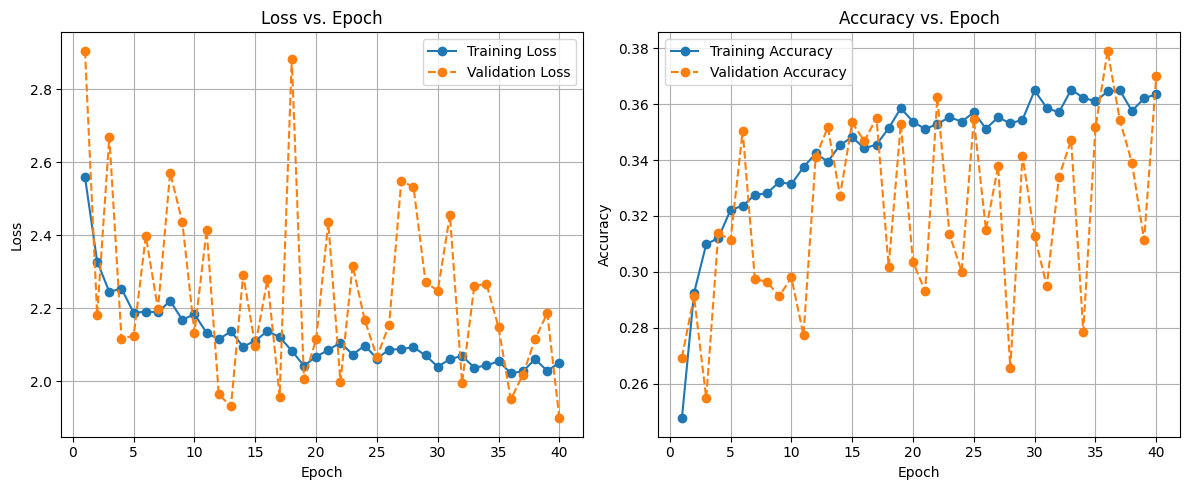

In [ ]:
# Training and validation loop
for epoch in range(1, 41):
    start_time = time.time()

    train_loss, train_accuracy = train(model, train_loader, criterion, optimizer, device)
    valid_loss, valid_accuracy = validate(model, valid_loader, criterion, device)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accuracies.append(train_accuracy.cpu().numpy())
    valid_accuracies.append(valid_accuracy.cpu().numpy())

    total_time += time.time() - start_time

    print(f"Epoch {epoch}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Validation Loss: {valid_loss:.4f}, Validation Accuracy: {valid_accuracy:.4f}")

    total_epochs += 1

# Print total training time
print(f"Total training time: {total_time:.2f} seconds")

# Plotting
plt.figure(figsize=(12, 5))

# Loss plots
plt.subplot(1, 2, 1)
plt.plot(range(1, total_epochs+1), train_losses, marker='o', label='Training Loss')
plt.plot(range(1, total_epochs+1), valid_losses, marker='o', label='Validation Loss', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch')
plt.legend()
plt.grid(True)

# Accuracy plots
plt.subplot(1, 2, 2)
plt.plot(range(1, total_epochs+1), train_accuracies, marker='o', label='Training Accuracy')
plt.plot(range(1, total_epochs+1), valid_accuracies, marker='o', label='Validation Accuracy', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epoch')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
#Fully connected feedforward Model
#Relu for hidden layer and softmax for outter layer

class MLPModel(nn.Module):
    def __init__(self):
        super(MLPModel, self).__init__()
        self.fc1 = nn.Linear(32*32*3, 1024)   # First hidden layer with 1024 neurons
        self.fc2 = nn.Linear(1024, 512)       # Second hidden layer with 512 neurons
        self.fc3 = nn.Linear(512, 256)        # Third hidden layer with 256 neurons
        self.fc4 = nn.Linear(256, 10)         # Output layer with 10 neurons (for 10 classes)

    def forward(self, x):
        x = x.view(x.size(0), -1)             # Flatten the input
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)                       # No activation on the final layer as it will be used with CrossEntropyLoss
        return x


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = MLPModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.03)


In [ ]:
# Lists to collect losses and accuracies for each epoch
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []

total_epochs = 0
total_time = 0

Epoch 1, Train Loss: 2.0929, Train Accuracy: 0.2265, Validation Loss: 1.9097, Validation Accuracy: 0.3145
Epoch 2, Train Loss: 1.8612, Train Accuracy: 0.3297, Validation Loss: 1.8009, Validation Accuracy: 0.3493
Epoch 3, Train Loss: 1.7572, Train Accuracy: 0.3679, Validation Loss: 1.6939, Validation Accuracy: 0.3900
Epoch 4, Train Loss: 1.6844, Train Accuracy: 0.3956, Validation Loss: 1.6825, Validation Accuracy: 0.3855
Epoch 5, Train Loss: 1.6289, Train Accuracy: 0.4173, Validation Loss: 1.6247, Validation Accuracy: 0.4163
Epoch 6, Train Loss: 1.5781, Train Accuracy: 0.4365, Validation Loss: 1.5617, Validation Accuracy: 0.4363
Epoch 7, Train Loss: 1.5379, Train Accuracy: 0.4505, Validation Loss: 1.5295, Validation Accuracy: 0.4509
Epoch 8, Train Loss: 1.5018, Train Accuracy: 0.4652, Validation Loss: 1.5170, Validation Accuracy: 0.4540
Epoch 9, Train Loss: 1.4651, Train Accuracy: 0.4770, Validation Loss: 1.4945, Validation Accuracy: 0.4704
Epoch 10, Train Loss: 1.4344, Train Accuracy: 

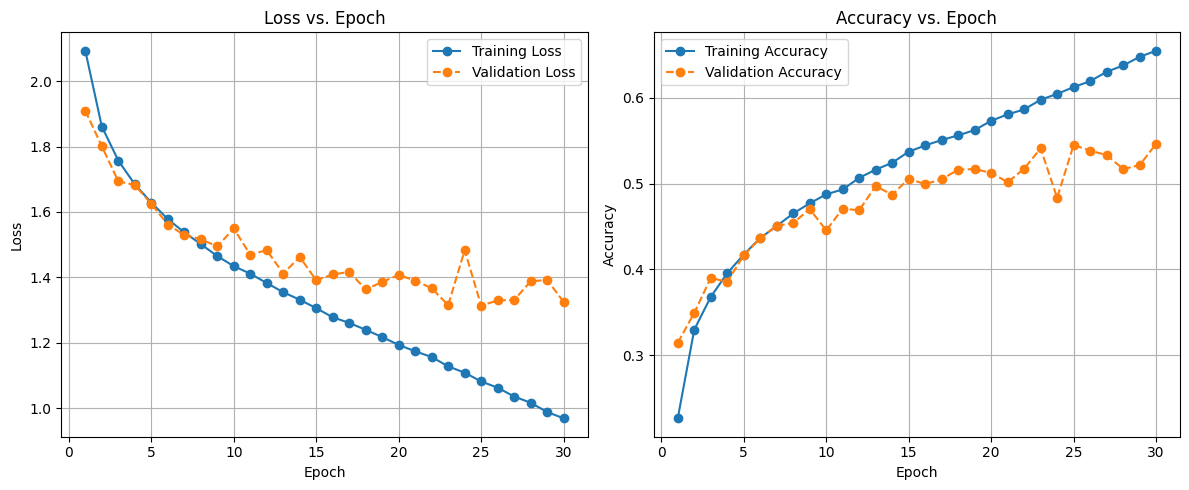

In [ ]:
# Training and validation loop
for epoch in range(1, 31):
    start_time = time.time()

    train_loss, train_accuracy = train(model, train_loader, criterion, optimizer, device)
    valid_loss, valid_accuracy = validate(model, valid_loader, criterion, device)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accuracies.append(train_accuracy.cpu().numpy())
    valid_accuracies.append(valid_accuracy.cpu().numpy())

    total_time += time.time() - start_time

    print(f"Epoch {epoch}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Validation Loss: {valid_loss:.4f}, Validation Accuracy: {valid_accuracy:.4f}")

    total_epochs += 1

# Print total training time
print(f"Total training time: {total_time:.2f} seconds")

# Plotting
plt.figure(figsize=(12, 5))

# Loss plots
plt.subplot(1, 2, 1)
plt.plot(range(1, total_epochs+1), train_losses, marker='o', label='Training Loss')
plt.plot(range(1, total_epochs+1), valid_losses, marker='o', label='Validation Loss', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch')
plt.legend()
plt.grid(True)

# Accuracy plots
plt.subplot(1, 2, 2)
plt.plot(range(1, total_epochs+1), train_accuracies, marker='o', label='Training Accuracy')
plt.plot(range(1, total_epochs+1), valid_accuracies, marker='o', label='Validation Accuracy', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epoch')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
#Fully connected feedforward Model
#Leaky Relu for hidden layers and softmax for outter layer
#with dropout layers to reduce overfitting
#with L2 regulization

class MLPModel_5(nn.Module):
    def __init__(self):
        super(MLPModel_5, self).__init__()
        self.fc1 = nn.Linear(32*32*3, 1024)   # First hidden layer with 1024 neurons
        self.fc2 = nn.Linear(1024, 256)        # Third hidden layer with 256 neurons
        self.fc3 = nn.Linear(256, 10)         # Output layer with 10 neurons (for 10 classes)

        # Dropout layers with 15% dropout rate for regularization
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.25)

    def forward(self, x):
        x = x.view(x.size(0), -1)             # Flatten the input
        x = F.leaky_relu(self.fc1(x))          # Leaky ReLU activation
        x = self.dropout1(x)
        x = F.leaky_relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = MLPModel_5().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.03, weight_decay=0.0001)

In [ ]:
# Lists to collect losses and accuracies for each epoch
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []

total_epochs = 0
total_time = 0

Epoch 1, Train Loss: 2.0270, Train Accuracy: 0.2616, Validation Loss: 1.8724, Validation Accuracy: 0.3269
Epoch 2, Train Loss: 1.8303, Train Accuracy: 0.3456, Validation Loss: 1.7506, Validation Accuracy: 0.3804
Epoch 3, Train Loss: 1.7482, Train Accuracy: 0.3747, Validation Loss: 1.7627, Validation Accuracy: 0.3678
Epoch 4, Train Loss: 1.6914, Train Accuracy: 0.3993, Validation Loss: 1.7211, Validation Accuracy: 0.3788
Epoch 5, Train Loss: 1.6503, Train Accuracy: 0.4163, Validation Loss: 1.6064, Validation Accuracy: 0.4250
Epoch 6, Train Loss: 1.6151, Train Accuracy: 0.4269, Validation Loss: 1.6021, Validation Accuracy: 0.4263
Epoch 7, Train Loss: 1.5800, Train Accuracy: 0.4405, Validation Loss: 1.5725, Validation Accuracy: 0.4341
Epoch 8, Train Loss: 1.5519, Train Accuracy: 0.4495, Validation Loss: 1.5249, Validation Accuracy: 0.4560
Epoch 9, Train Loss: 1.5268, Train Accuracy: 0.4592, Validation Loss: 1.5195, Validation Accuracy: 0.4585
Epoch 10, Train Loss: 1.5044, Train Accuracy: 

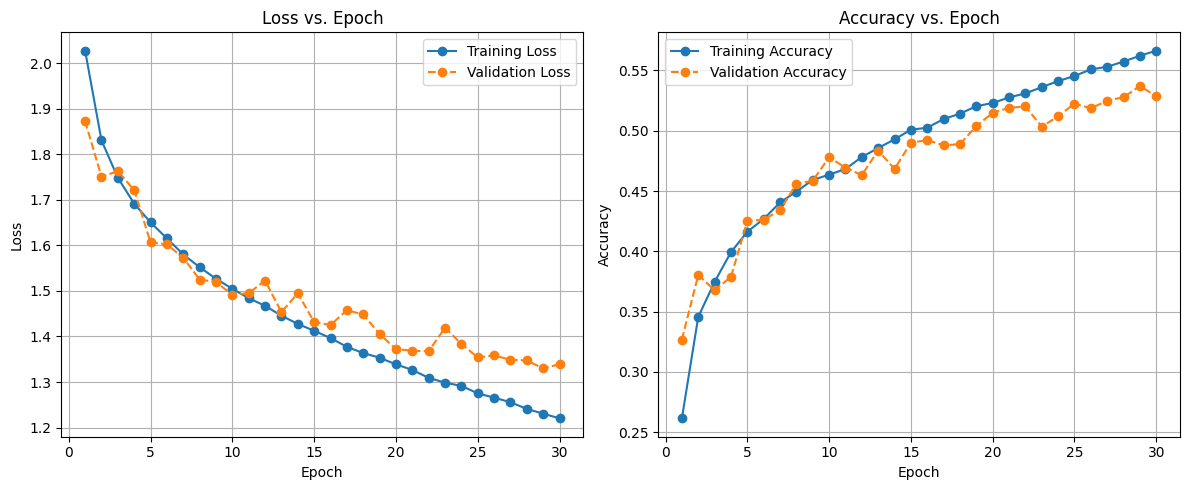

In [ ]:

# Training and validation loop
for epoch in range(1, 31):
    start_time = time.time()

    train_loss, train_accuracy = train(model, train_loader, criterion, optimizer, device)
    valid_loss, valid_accuracy = validate(model, valid_loader, criterion, device)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accuracies.append(train_accuracy.cpu().numpy())
    valid_accuracies.append(valid_accuracy.cpu().numpy())

    total_time += time.time() - start_time

    print(f"Epoch {epoch}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Validation Loss: {valid_loss:.4f}, Validation Accuracy: {valid_accuracy:.4f}")

    total_epochs += 1

# Print total training time
print(f"Total training time: {total_time:.2f} seconds")

# Plotting
plt.figure(figsize=(12, 5))

# Loss plots
plt.subplot(1, 2, 1)
plt.plot(range(1, total_epochs+1), train_losses, marker='o', label='Training Loss')
plt.plot(range(1, total_epochs+1), valid_losses, marker='o', label='Validation Loss', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch')
plt.legend()
plt.grid(True)

# Accuracy plots
plt.subplot(1, 2, 2)
plt.plot(range(1, total_epochs+1), train_accuracies, marker='o', label='Training Accuracy')
plt.plot(range(1, total_epochs+1), valid_accuracies, marker='o', label='Validation Accuracy', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epoch')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
# Convolutional neural nets
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()

        # Convolutional Layer 1
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)

        # Convolutional Layer 2
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)

        # Convolutional Layer 3
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)

        # Max Pooling Layer (used after every convolutional layer to reduce spatial dimensions)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Fully Connected Layer
        self.fc1 = nn.Linear(128 * 4 * 4, 512)  # The spatial size reduces to 4x4 after 3 pooling layers
        self.fc2 = nn.Linear(512, 10)

        # Dropout layers with 20% dropout rate for regularization
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.2)

    def forward(self, x):
        # Conv -> LeakyReLU -> Pool
        x = self.pool(F.leaky_relu(self.conv1(x)))
        x = self.dropout1(x)

        x = self.pool(F.leaky_relu(self.conv2(x)))
        x = self.dropout1(x)

        x = self.pool(F.leaky_relu(self.conv3(x)))
        x = self.dropout2(x)

        # Flatten the tensor
        x = x.view(-1, 128 * 4 * 4)

        # Fully Connected Layers
        x = F.leaky_relu(self.fc1(x))
        x = self.fc2(x)

        return x


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = CNNModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.03, weight_decay=0.0001)

In [ ]:
# Lists to collect losses and accuracies for each epoch
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []

total_epochs = 0
total_time = 0

Epoch 1, Train Loss: 2.1886, Train Accuracy: 0.1862, Validation Loss: 2.0044, Validation Accuracy: 0.2670
Epoch 2, Train Loss: 1.9134, Train Accuracy: 0.3109, Validation Loss: 1.8134, Validation Accuracy: 0.3524
Epoch 3, Train Loss: 1.7115, Train Accuracy: 0.3854, Validation Loss: 1.6715, Validation Accuracy: 0.3893
Epoch 4, Train Loss: 1.5580, Train Accuracy: 0.4397, Validation Loss: 1.4803, Validation Accuracy: 0.4705
Epoch 5, Train Loss: 1.4630, Train Accuracy: 0.4727, Validation Loss: 1.3951, Validation Accuracy: 0.4978
Epoch 6, Train Loss: 1.3729, Train Accuracy: 0.5063, Validation Loss: 1.3391, Validation Accuracy: 0.5134
Epoch 7, Train Loss: 1.3037, Train Accuracy: 0.5323, Validation Loss: 1.2518, Validation Accuracy: 0.5473
Epoch 8, Train Loss: 1.2412, Train Accuracy: 0.5564, Validation Loss: 1.1935, Validation Accuracy: 0.5763
Epoch 9, Train Loss: 1.1793, Train Accuracy: 0.5807, Validation Loss: 1.1394, Validation Accuracy: 0.5934
Epoch 10, Train Loss: 1.1243, Train Accuracy: 

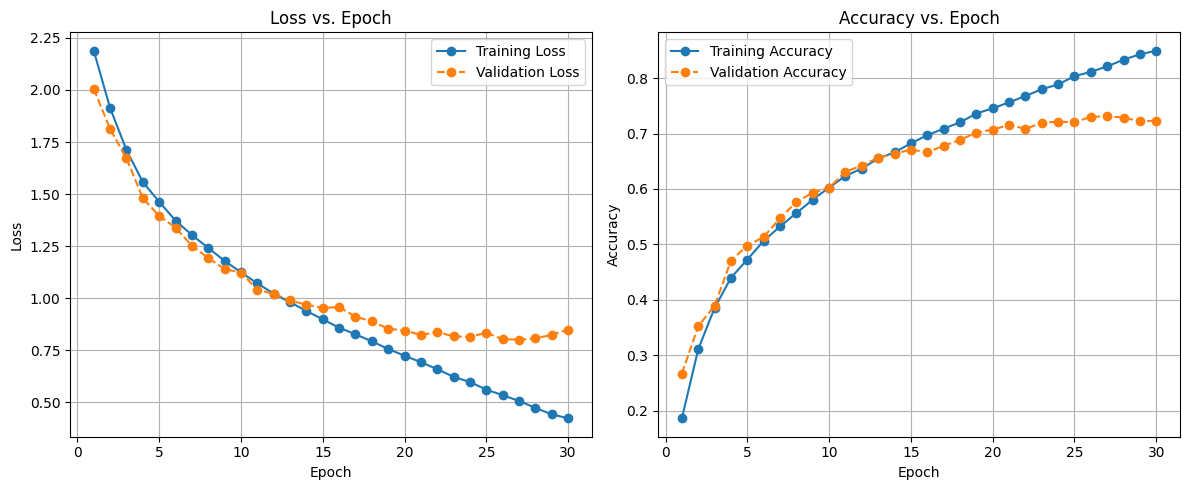

In [ ]:

# Training and validation loop
for epoch in range(1, 31):
    start_time = time.time()

    train_loss, train_accuracy = train(model, train_loader, criterion, optimizer, device)
    valid_loss, valid_accuracy = validate(model, valid_loader, criterion, device)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accuracies.append(train_accuracy.cpu().numpy())
    valid_accuracies.append(valid_accuracy.cpu().numpy())

    total_time += time.time() - start_time

    print(f"Epoch {epoch}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Validation Loss: {valid_loss:.4f}, Validation Accuracy: {valid_accuracy:.4f}")

    total_epochs += 1

# Print total training time
print(f"Total training time: {total_time:.2f} seconds")

# Plotting
plt.figure(figsize=(12, 5))

# Loss plots
plt.subplot(1, 2, 1)
plt.plot(range(1, total_epochs+1), train_losses, marker='o', label='Training Loss')
plt.plot(range(1, total_epochs+1), valid_losses, marker='o', label='Validation Loss', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch')
plt.legend()
plt.grid(True)

# Accuracy plots
plt.subplot(1, 2, 2)
plt.plot(range(1, total_epochs+1), train_accuracies, marker='o', label='Training Accuracy')
plt.plot(range(1, total_epochs+1), valid_accuracies, marker='o', label='Validation Accuracy', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epoch')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
# for gray scale image
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert RGB to Grayscale
    transforms.ToTensor()  # Convert the image to a tensor
])

# Load the CIFAR10 dataset
cifar10 = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Define the CIFAR10 class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Files already downloaded and verified


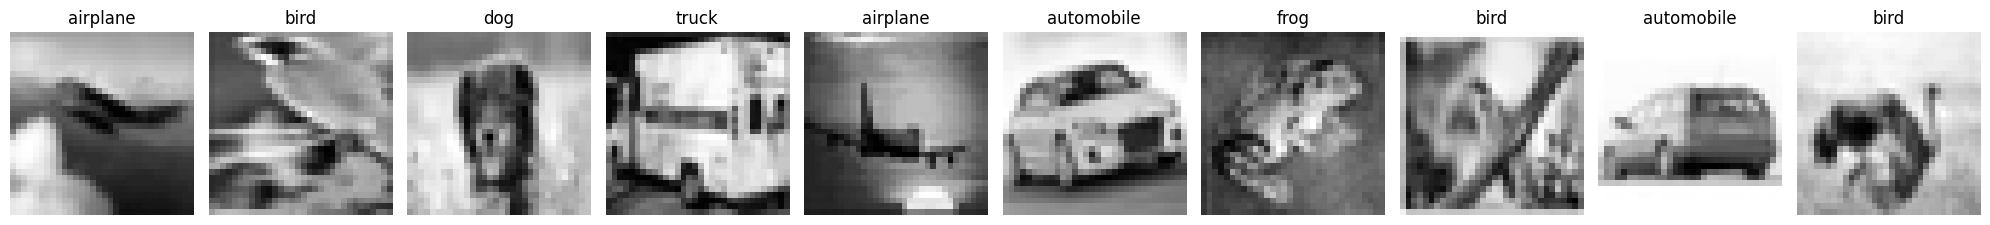

In [ ]:
#for gray scale
# Randomly choose 10 images from the dataset
indices = np.random.choice(range(len(cifar10)), 10, replace=False)
random_images = [cifar10[i][0] for i in indices]
random_labels = [cifar10[i][1] for i in indices]

# Plot the images with their labels
plt.figure(figsize=(20, 4))
for idx, (image, label) in enumerate(zip(random_images, random_labels)):
    plt.subplot(1, 10, idx + 1)
    image = image.squeeze(0)  # Convert the image from [32, 32, 1] to [32, 32]
    plt.imshow(image, cmap='gray')
    plt.title(class_names[label])
    plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
#Benchmark Model
#Singal layer fully connected
class BenchmarkModel(nn.Module):
    def __init__(self):
        super(BenchmarkModel, self).__init__()
        self.fc = nn.Linear(32*32, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

Epoch 1, Train Loss: 2.1340, Train Accuracy: 0.2252, Validation Loss: 2.1080, Validation Accuracy: 0.2210
Epoch 2, Train Loss: 2.0784, Train Accuracy: 0.2568, Validation Loss: 2.0568, Validation Accuracy: 0.2667
Epoch 3, Train Loss: 2.0614, Train Accuracy: 0.2684, Validation Loss: 2.0832, Validation Accuracy: 0.2664
Epoch 4, Train Loss: 2.0556, Train Accuracy: 0.2692, Validation Loss: 2.0614, Validation Accuracy: 0.2641
Epoch 5, Train Loss: 2.0477, Train Accuracy: 0.2764, Validation Loss: 2.0440, Validation Accuracy: 0.2888
Epoch 6, Train Loss: 2.0429, Train Accuracy: 0.2803, Validation Loss: 2.0700, Validation Accuracy: 0.2753
Epoch 7, Train Loss: 2.0374, Train Accuracy: 0.2830, Validation Loss: 2.0904, Validation Accuracy: 0.2451
Epoch 8, Train Loss: 2.0349, Train Accuracy: 0.2829, Validation Loss: 2.0615, Validation Accuracy: 0.2746
Epoch 9, Train Loss: 2.0286, Train Accuracy: 0.2875, Validation Loss: 2.0506, Validation Accuracy: 0.2794
Epoch 10, Train Loss: 2.0284, Train Accuracy: 

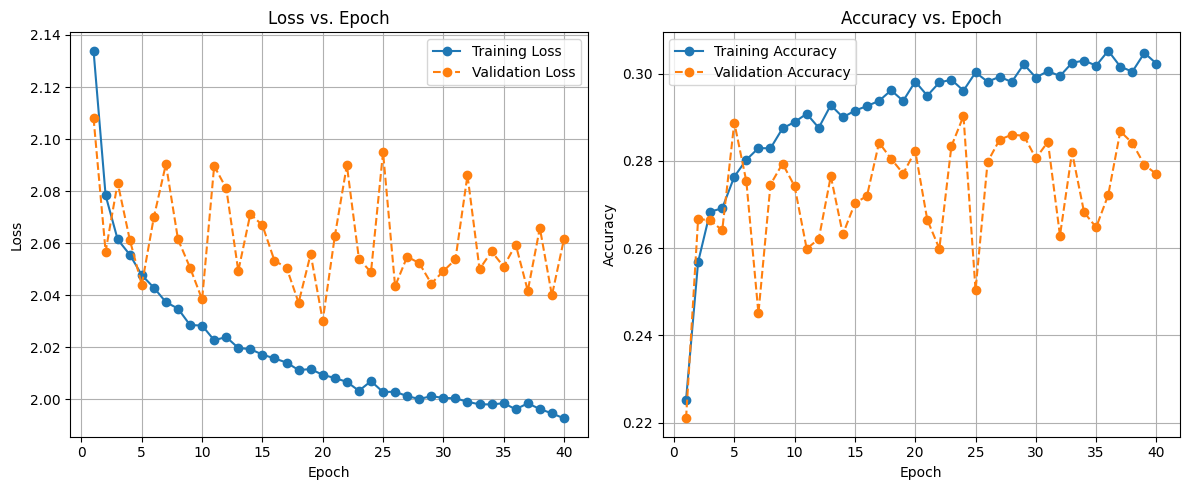

In [ ]:
#for gray scale images
# Training and validation loop
for epoch in range(1, 41):
    start_time = time.time()

    train_loss, train_accuracy = train(model, train_loader, criterion, optimizer, device)
    valid_loss, valid_accuracy = validate(model, valid_loader, criterion, device)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accuracies.append(train_accuracy.cpu().numpy())
    valid_accuracies.append(valid_accuracy.cpu().numpy())

    total_time += time.time() - start_time

    print(f"Epoch {epoch}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Validation Loss: {valid_loss:.4f}, Validation Accuracy: {valid_accuracy:.4f}")

    total_epochs += 1

# Print total training time
print(f"Total training time: {total_time:.2f} seconds")

# Plotting
plt.figure(figsize=(12, 5))

# Loss plots
plt.subplot(1, 2, 1)
plt.plot(range(1, total_epochs+1), train_losses, marker='o', label='Training Loss')
plt.plot(range(1, total_epochs+1), valid_losses, marker='o', label='Validation Loss', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch')
plt.legend()
plt.grid(True)

# Accuracy plots
plt.subplot(1, 2, 2)
plt.plot(range(1, total_epochs+1), train_accuracies, marker='o', label='Training Accuracy')
plt.plot(range(1, total_epochs+1), valid_accuracies, marker='o', label='Validation Accuracy', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epoch')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
#Fully connected feedforward Model
#Leaky Relu for hidden layers and softmax for outter layer
#with dropout layers to reduce overfitting
#with L2 regulization

class MLPModel_5(nn.Module):
    def __init__(self):
        super(MLPModel_5, self).__init__()
        self.fc1 = nn.Linear(32*32, 512)   # First hidden layer with 1024 neurons
        self.fc2 = nn.Linear(512, 256)        # Third hidden layer with 256 neurons
        self.fc3 = nn.Linear(256, 10)         # Output layer with 10 neurons (for 10 classes)

        # Dropout layers with 15% dropout rate for regularization
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.25)

    def forward(self, x):
        x = x.view(x.size(0), -1)             # Flatten the input
        x = F.leaky_relu(self.fc1(x))          # Leaky ReLU activation
        x = self.dropout1(x)
        x = F.leaky_relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x


Epoch 1, Train Loss: 1.2971, Train Accuracy: 0.5370, Validation Loss: 1.5334, Validation Accuracy: 0.4545
Epoch 2, Train Loss: 1.2907, Train Accuracy: 0.5401, Validation Loss: 1.5091, Validation Accuracy: 0.4682
Epoch 3, Train Loss: 1.2883, Train Accuracy: 0.5415, Validation Loss: 1.5228, Validation Accuracy: 0.4633
Epoch 4, Train Loss: 1.2807, Train Accuracy: 0.5447, Validation Loss: 1.5206, Validation Accuracy: 0.4621
Epoch 5, Train Loss: 1.2766, Train Accuracy: 0.5483, Validation Loss: 1.5266, Validation Accuracy: 0.4600
Epoch 6, Train Loss: 1.2740, Train Accuracy: 0.5464, Validation Loss: 1.5153, Validation Accuracy: 0.4659
Epoch 7, Train Loss: 1.2620, Train Accuracy: 0.5513, Validation Loss: 1.5033, Validation Accuracy: 0.4654
Epoch 8, Train Loss: 1.2590, Train Accuracy: 0.5525, Validation Loss: 1.5163, Validation Accuracy: 0.4656
Epoch 9, Train Loss: 1.2579, Train Accuracy: 0.5521, Validation Loss: 1.4944, Validation Accuracy: 0.4749
Epoch 10, Train Loss: 1.2528, Train Accuracy: 

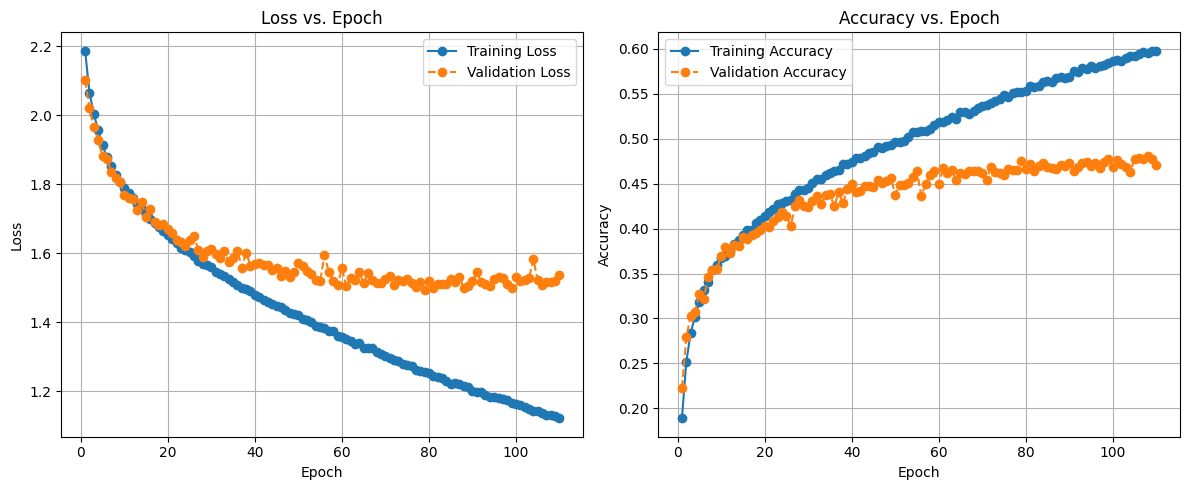

In [ ]:

# Training and validation loop
for epoch in range(1, 41):
    start_time = time.time()

    train_loss, train_accuracy = train(model, train_loader, criterion, optimizer, device)
    valid_loss, valid_accuracy = validate(model, valid_loader, criterion, device)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accuracies.append(train_accuracy.cpu().numpy())
    valid_accuracies.append(valid_accuracy.cpu().numpy())

    total_time += time.time() - start_time

    print(f"Epoch {epoch}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Validation Loss: {valid_loss:.4f}, Validation Accuracy: {valid_accuracy:.4f}")

    total_epochs += 1

# Print total training time
print(f"Total training time: {total_time:.2f} seconds")

# Plotting
plt.figure(figsize=(12, 5))

# Loss plots
plt.subplot(1, 2, 1)
plt.plot(range(1, total_epochs+1), train_losses, marker='o', label='Training Loss')
plt.plot(range(1, total_epochs+1), valid_losses, marker='o', label='Validation Loss', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch')
plt.legend()
plt.grid(True)

# Accuracy plots
plt.subplot(1, 2, 2)
plt.plot(range(1, total_epochs+1), train_accuracies, marker='o', label='Training Accuracy')
plt.plot(range(1, total_epochs+1), valid_accuracies, marker='o', label='Validation Accuracy', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epoch')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
# Convolutional neural nets
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()

        # Convolutional Layer 1
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)

        # Convolutional Layer 2
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)

        # Convolutional Layer 3
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)

        # Max Pooling Layer (used after every convolutional layer to reduce spatial dimensions)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Fully Connected Layer
        self.fc1 = nn.Linear(128 * 4 * 4, 512)  # The spatial size reduces to 4x4 after 3 pooling layers
        self.fc2 = nn.Linear(512, 10)

        # Dropout layers with 20% dropout rate for regularization
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.2)

    def forward(self, x):
        # Conv -> LeakyReLU -> Pool
        x = self.pool(F.leaky_relu(self.conv1(x)))
        x = self.dropout1(x)

        x = self.pool(F.leaky_relu(self.conv2(x)))
        x = self.dropout1(x)

        x = self.pool(F.leaky_relu(self.conv3(x)))
        x = self.dropout2(x)

        # Flatten the tensor
        x = x.view(-1, 128 * 4 * 4)

        # Fully Connected Layers
        x = F.leaky_relu(self.fc1(x))
        x = self.fc2(x)

        return x


Epoch 1, Train Loss: 0.5043, Train Accuracy: 0.8245, Validation Loss: 0.9054, Validation Accuracy: 0.7013
Epoch 2, Train Loss: 0.4804, Train Accuracy: 0.8335, Validation Loss: 0.9180, Validation Accuracy: 0.7017
Epoch 3, Train Loss: 0.4519, Train Accuracy: 0.8437, Validation Loss: 0.9143, Validation Accuracy: 0.7058
Epoch 4, Train Loss: 0.4266, Train Accuracy: 0.8521, Validation Loss: 0.9258, Validation Accuracy: 0.7049
Epoch 5, Train Loss: 0.3991, Train Accuracy: 0.8603, Validation Loss: 0.9368, Validation Accuracy: 0.7026
Epoch 6, Train Loss: 0.3738, Train Accuracy: 0.8710, Validation Loss: 0.9699, Validation Accuracy: 0.7004
Epoch 7, Train Loss: 0.3530, Train Accuracy: 0.8776, Validation Loss: 0.9498, Validation Accuracy: 0.7104
Epoch 8, Train Loss: 0.3366, Train Accuracy: 0.8820, Validation Loss: 0.9758, Validation Accuracy: 0.7033
Epoch 9, Train Loss: 0.3140, Train Accuracy: 0.8909, Validation Loss: 1.0351, Validation Accuracy: 0.6981
Epoch 10, Train Loss: 0.3016, Train Accuracy: 

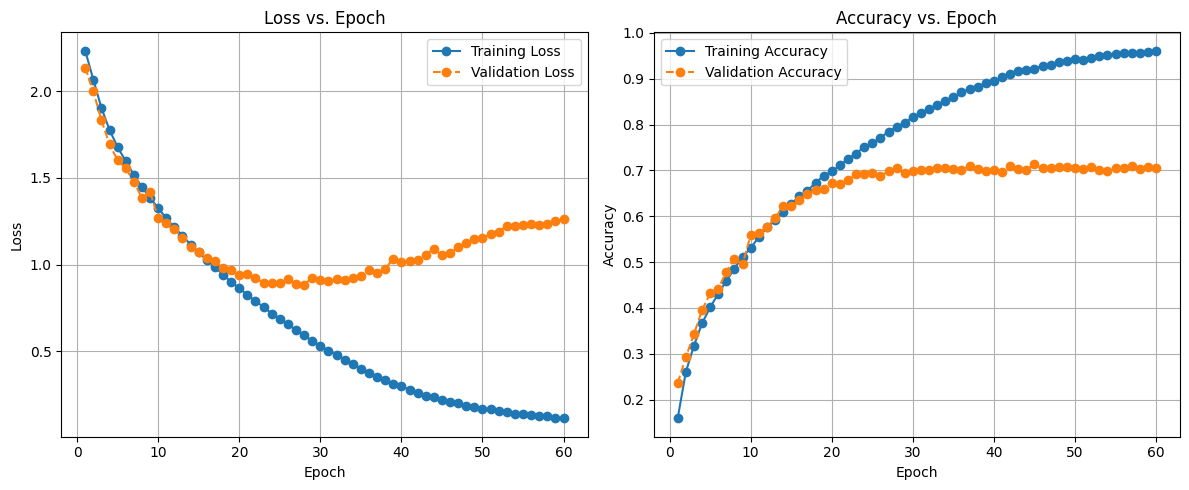

In [ ]:

# Training and validation loop
for epoch in range(1, 31):
    start_time = time.time()

    train_loss, train_accuracy = train(model, train_loader, criterion, optimizer, device)
    valid_loss, valid_accuracy = validate(model, valid_loader, criterion, device)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accuracies.append(train_accuracy.cpu().numpy())
    valid_accuracies.append(valid_accuracy.cpu().numpy())

    total_time += time.time() - start_time

    print(f"Epoch {epoch}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Validation Loss: {valid_loss:.4f}, Validation Accuracy: {valid_accuracy:.4f}")

    total_epochs += 1

# Print total training time
print(f"Total training time: {total_time:.2f} seconds")

# Plotting
plt.figure(figsize=(12, 5))

# Loss plots
plt.subplot(1, 2, 1)
plt.plot(range(1, total_epochs+1), train_losses, marker='o', label='Training Loss')
plt.plot(range(1, total_epochs+1), valid_losses, marker='o', label='Validation Loss', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch')
plt.legend()
plt.grid(True)

# Accuracy plots
plt.subplot(1, 2, 2)
plt.plot(range(1, total_epochs+1), train_accuracies, marker='o', label='Training Accuracy')
plt.plot(range(1, total_epochs+1), valid_accuracies, marker='o', label='Validation Accuracy', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epoch')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
# Create filters for edge detection
horizontal_filter = torch.tensor([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], dtype=torch.float32).unsqueeze(0).unsqueeze(0)
vertical_filter = torch.tensor([[1, 0, -1], [2, 0, -2], [1, 0, -1]], dtype=torch.float32).unsqueeze(0).unsqueeze(0)

class EdgeDetectionCIFAR10(datasets.CIFAR10):
    def __getitem__(self, index):
        # Get the original image and label
        img, label = super(EdgeDetectionCIFAR10, self).__getitem__(index)

        # Convert the image to a batch of 1 to use with conv2d
        img_batch = img.unsqueeze(0)

        # Apply the filters
        img_horizontal = F.conv2d(img_batch, horizontal_filter, padding=1)
        img_vertical = F.conv2d(img_batch, vertical_filter, padding=1)

        # Concatenate the results
        processed_img = torch.cat([img_horizontal, img_vertical], dim=1).squeeze(0)

        return processed_img, label

# Define your transform
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert RGB to Grayscale
    transforms.ToTensor()  # Convert the image to a tensor
])

# Load the CIFAR10 dataset with edge detection
cifar10 = EdgeDetectionCIFAR10(root='./data', train=True, download=True, transform=transform)

# Define the CIFAR10 class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']




Files already downloaded and verified


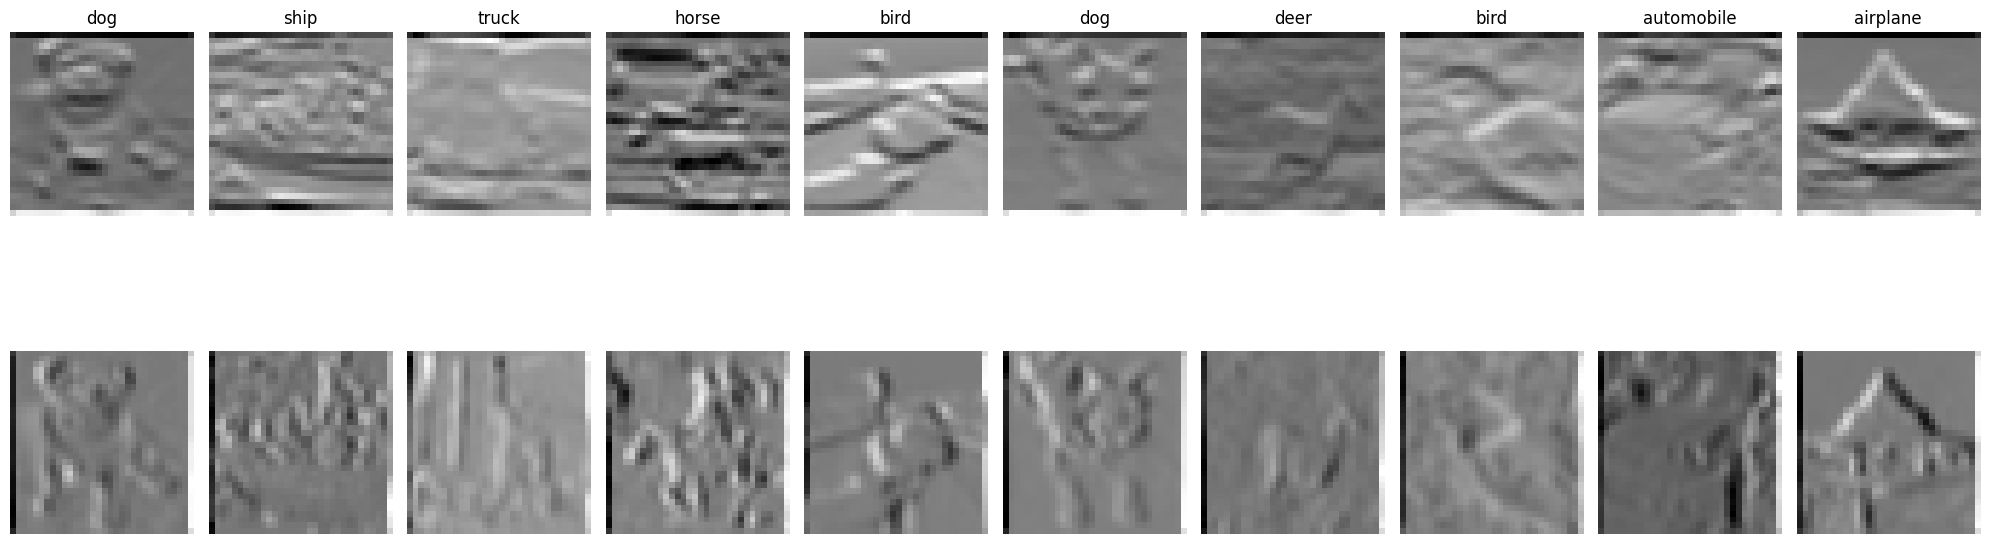

In [ ]:
#for gray scale

# Randomly choose 10 images from the dataset
indices = np.random.choice(range(len(cifar10)), 10, replace=False)
random_images = [cifar10[i][0] for i in indices]
random_labels = [cifar10[i][1] for i in indices]

# Plot the images with their labels
plt.figure(figsize=(20, 8))
for idx, (image, label) in enumerate(zip(random_images, random_labels)):

    # Display horizontal edges
    plt.subplot(2, 10, idx + 1)
    horizontal_image = image[0].numpy()  # Extract the horizontal channel
    plt.imshow(horizontal_image, cmap='gray')
    if idx == 0:
        plt.ylabel("Horizontal", fontsize=14)
    plt.title(class_names[label])
    plt.axis('off')

    # Display vertical edges
    plt.subplot(2, 10, idx + 11)  # Offset by 10 for second row
    vertical_image = image[1].numpy()  # Extract the vertical channel
    plt.imshow(vertical_image, cmap='gray')
    if idx == 0:
        plt.ylabel("Vertical", fontsize=14)
    plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
# Convolutional neural nets
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()

        # Convolutional Layer 1
        self.conv1 = nn.Conv2d(in_channels=2, out_channels=32, kernel_size=3, padding=1)

        # Convolutional Layer 2
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)

        # Convolutional Layer 3
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)

        # Max Pooling Layer (used after every convolutional layer to reduce spatial dimensions)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Fully Connected Layer
        self.fc1 = nn.Linear(128 * 4 * 4, 512)  # The spatial size reduces to 4x4 after 3 pooling layers
        self.fc2 = nn.Linear(512, 10)

        # Dropout layers with 20% dropout rate for regularization
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.2)

    def forward(self, x):
        # Conv -> LeakyReLU -> Pool
        x = self.pool(F.leaky_relu(self.conv1(x)))
        x = self.dropout1(x)

        x = self.pool(F.leaky_relu(self.conv2(x)))
        x = self.dropout1(x)

        x = self.pool(F.leaky_relu(self.conv3(x)))
        x = self.dropout2(x)

        # Flatten the tensor
        x = x.view(-1, 128 * 4 * 4)

        # Fully Connected Layers
        x = F.leaky_relu(self.fc1(x))
        x = self.fc2(x)

        return x


Epoch 1, Train Loss: 2.0468, Train Accuracy: 0.2419, Validation Loss: 1.7498, Validation Accuracy: 0.3648
Epoch 2, Train Loss: 1.6566, Train Accuracy: 0.4058, Validation Loss: 1.5060, Validation Accuracy: 0.4795
Epoch 3, Train Loss: 1.4649, Train Accuracy: 0.4856, Validation Loss: 1.3414, Validation Accuracy: 0.5330
Epoch 4, Train Loss: 1.3085, Train Accuracy: 0.5471, Validation Loss: 1.2194, Validation Accuracy: 0.5731
Epoch 5, Train Loss: 1.1767, Train Accuracy: 0.5921, Validation Loss: 1.1156, Validation Accuracy: 0.6141
Epoch 6, Train Loss: 1.0815, Train Accuracy: 0.6233, Validation Loss: 1.0386, Validation Accuracy: 0.6402
Epoch 7, Train Loss: 1.0020, Train Accuracy: 0.6535, Validation Loss: 0.9689, Validation Accuracy: 0.6604
Epoch 8, Train Loss: 0.9321, Train Accuracy: 0.6766, Validation Loss: 0.9019, Validation Accuracy: 0.6843
Epoch 9, Train Loss: 0.8714, Train Accuracy: 0.6967, Validation Loss: 0.8574, Validation Accuracy: 0.7109
Epoch 10, Train Loss: 0.8257, Train Accuracy: 

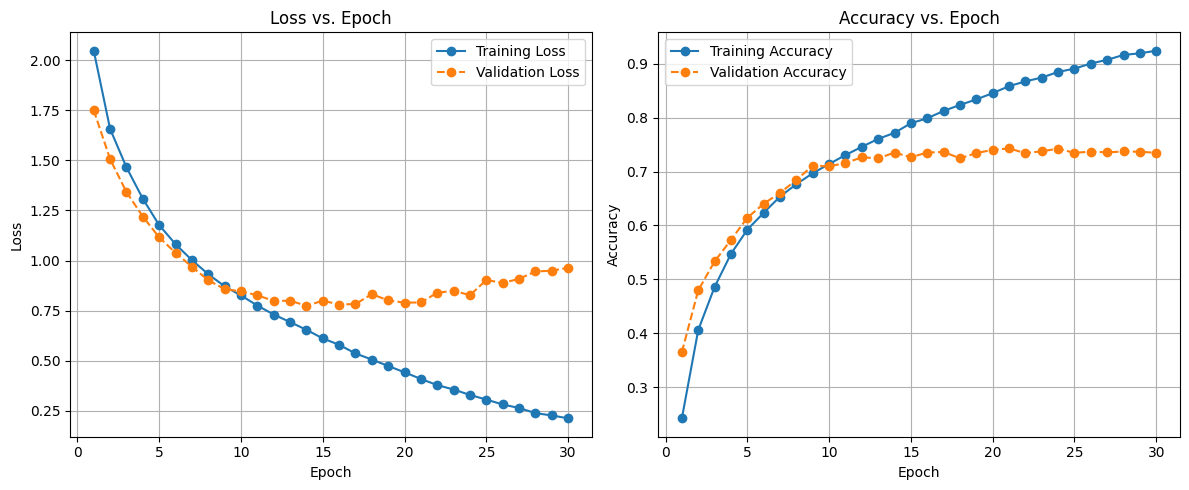

In [ ]:

# Training and validation loop
for epoch in range(1, 31):
    start_time = time.time()

    train_loss, train_accuracy = train(model, train_loader, criterion, optimizer, device)
    valid_loss, valid_accuracy = validate(model, valid_loader, criterion, device)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accuracies.append(train_accuracy.cpu().numpy())
    valid_accuracies.append(valid_accuracy.cpu().numpy())

    total_time += time.time() - start_time

    print(f"Epoch {epoch}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Validation Loss: {valid_loss:.4f}, Validation Accuracy: {valid_accuracy:.4f}")

    total_epochs += 1

# Print total training time
print(f"Total training time: {total_time:.2f} seconds")

# Plotting
plt.figure(figsize=(12, 5))

# Loss plots
plt.subplot(1, 2, 1)
plt.plot(range(1, total_epochs+1), train_losses, marker='o', label='Training Loss')
plt.plot(range(1, total_epochs+1), valid_losses, marker='o', label='Validation Loss', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch')
plt.legend()
plt.grid(True)

# Accuracy plots
plt.subplot(1, 2, 2)
plt.plot(range(1, total_epochs+1), train_accuracies, marker='o', label='Training Accuracy')
plt.plot(range(1, total_epochs+1), valid_accuracies, marker='o', label='Validation Accuracy', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epoch')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
#Fully connected feedforward Model
#Leaky Relu for hidden layers and softmax for outter layer
#with dropout layers to reduce overfitting
#with L2 regulization

class MLPModel_5(nn.Module):
    def __init__(self):
        super(MLPModel_5, self).__init__()
        self.fc1 = nn.Linear(32*32*2, 512)   # First hidden layer with 1024 neurons
        self.fc2 = nn.Linear(512, 256)        # Third hidden layer with 256 neurons
        self.fc3 = nn.Linear(256, 10)         # Output layer with 10 neurons (for 10 classes)

        # Dropout layers with 15% dropout rate for regularization
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.25)

    def forward(self, x):
        x = x.view(x.size(0), -1)             # Flatten the input
        x = F.leaky_relu(self.fc1(x))          # Leaky ReLU activation
        x = self.dropout1(x)
        x = F.leaky_relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x


In [ ]:

# Training and validation loop
for epoch in range(1, 31):
    start_time = time.time()

    train_loss, train_accuracy = train(model, train_loader, criterion, optimizer, device)
    valid_loss, valid_accuracy = validate(model, valid_loader, criterion, device)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accuracies.append(train_accuracy.cpu().numpy())
    valid_accuracies.append(valid_accuracy.cpu().numpy())

    total_time += time.time() - start_time

    print(f"Epoch {epoch}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Validation Loss: {valid_loss:.4f}, Validation Accuracy: {valid_accuracy:.4f}")

    total_epochs += 1

# Print total training time
print(f"Total training time: {total_time:.2f} seconds")

# Plotting
plt.figure(figsize=(12, 5))

# Loss plots
plt.subplot(1, 2, 1)
plt.plot(range(1, total_epochs+1), train_losses, marker='o', label='Training Loss')
plt.plot(range(1, total_epochs+1), valid_losses, marker='o', label='Validation Loss', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch')
plt.legend()
plt.grid(True)

# Accuracy plots
plt.subplot(1, 2, 2)
plt.plot(range(1, total_epochs+1), train_accuracies, marker='o', label='Training Accuracy')
plt.plot(range(1, total_epochs+1), valid_accuracies, marker='o', label='Validation Accuracy', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epoch')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
#Benchmark Model
#Singal layer fully connected
class BenchmarkModel(nn.Module):
    def __init__(self):
        super(BenchmarkModel, self).__init__()
        self.fc = nn.Linear(32*32*2, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [ ]:

# Training and validation loop
for epoch in range(1, 31):
    start_time = time.time()

    train_loss, train_accuracy = train(model, train_loader, criterion, optimizer, device)
    valid_loss, valid_accuracy = validate(model, valid_loader, criterion, device)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accuracies.append(train_accuracy.cpu().numpy())
    valid_accuracies.append(valid_accuracy.cpu().numpy())

    total_time += time.time() - start_time

    print(f"Epoch {epoch}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Validation Loss: {valid_loss:.4f}, Validation Accuracy: {valid_accuracy:.4f}")

    total_epochs += 1

# Print total training time
print(f"Total training time: {total_time:.2f} seconds")

# Plotting
plt.figure(figsize=(12, 5))

# Loss plots
plt.subplot(1, 2, 1)
plt.plot(range(1, total_epochs+1), train_losses, marker='o', label='Training Loss')
plt.plot(range(1, total_epochs+1), valid_losses, marker='o', label='Validation Loss', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch')
plt.legend()
plt.grid(True)

# Accuracy plots
plt.subplot(1, 2, 2)
plt.plot(range(1, total_epochs+1), train_accuracies, marker='o', label='Training Accuracy')
plt.plot(range(1, total_epochs+1), valid_accuracies, marker='o', label='Validation Accuracy', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epoch')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


Epoch 1, Train Loss: 2.3806, Train Accuracy: 0.2154, Validation Loss: 2.7999, Validation Accuracy: 0.2052
Epoch 2, Train Loss: 2.3420, Train Accuracy: 0.2277, Validation Loss: 2.2953, Validation Accuracy: 0.2168
Epoch 3, Train Loss: 2.3189, Train Accuracy: 0.2355, Validation Loss: 2.1933, Validation Accuracy: 0.2432
Epoch 4, Train Loss: 2.3022, Train Accuracy: 0.2400, Validation Loss: 2.3129, Validation Accuracy: 0.2149
Epoch 5, Train Loss: 2.3093, Train Accuracy: 0.2434, Validation Loss: 2.2259, Validation Accuracy: 0.2481
Epoch 6, Train Loss: 2.2850, Train Accuracy: 0.2442, Validation Loss: 2.3102, Validation Accuracy: 0.2297
Epoch 7, Train Loss: 2.2826, Train Accuracy: 0.2406, Validation Loss: 2.2765, Validation Accuracy: 0.2334
Epoch 8, Train Loss: 2.2742, Train Accuracy: 0.2447, Validation Loss: 2.3028, Validation Accuracy: 0.2120
Epoch 9, Train Loss: 2.2663, Train Accuracy: 0.2486, Validation Loss: 2.3622, Validation Accuracy: 0.2238
Epoch 10, Train Loss: 2.2877, Train Accuracy: 

KeyboardInterrupt: ignored

In [ ]:

# Create filters for edge detection
horizontal_filter = torch.tensor([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], dtype=torch.float32).unsqueeze(0).unsqueeze(0)
vertical_filter = torch.tensor([[1, 0, -1], [2, 0, -2], [1, 0, -1]], dtype=torch.float32).unsqueeze(0).unsqueeze(0)

# Extend filters to apply on RGB images
horizontal_filter_rgb = horizontal_filter.repeat(3, 1, 1, 1)  # Extend to [3, 1, 3, 3]
vertical_filter_rgb = vertical_filter.repeat(3, 1, 1, 1)     # Extend to [3, 1, 3, 3]

class EdgeDetectionCIFAR10(datasets.CIFAR10):
    def __getitem__(self, index):
        # Get the original image and label
        img, label = datasets.CIFAR10.__getitem__(self, index)

        # Convert the image to a batch of 1 to use with conv2d
        img_batch = img.unsqueeze(0)

        # Apply the filters
        img_horizontal = F.conv2d(img_batch, horizontal_filter_rgb, padding=1, groups=3)
        img_vertical = F.conv2d(img_batch, vertical_filter_rgb, padding=1, groups=3)

        # Concatenate the results
        processed_img = torch.cat([img_horizontal, img_vertical], dim=1).squeeze(0)

        return processed_img, label

# Define your transform
transform = transforms.Compose([
    transforms.ToTensor()  # Convert the image to a tensor
])

# Load the CIFAR10 dataset with edge detection
cifar10 = EdgeDetectionCIFAR10(root='./data', train=True, download=True, transform=transform)

# Define the CIFAR10 class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Files already downloaded and verified


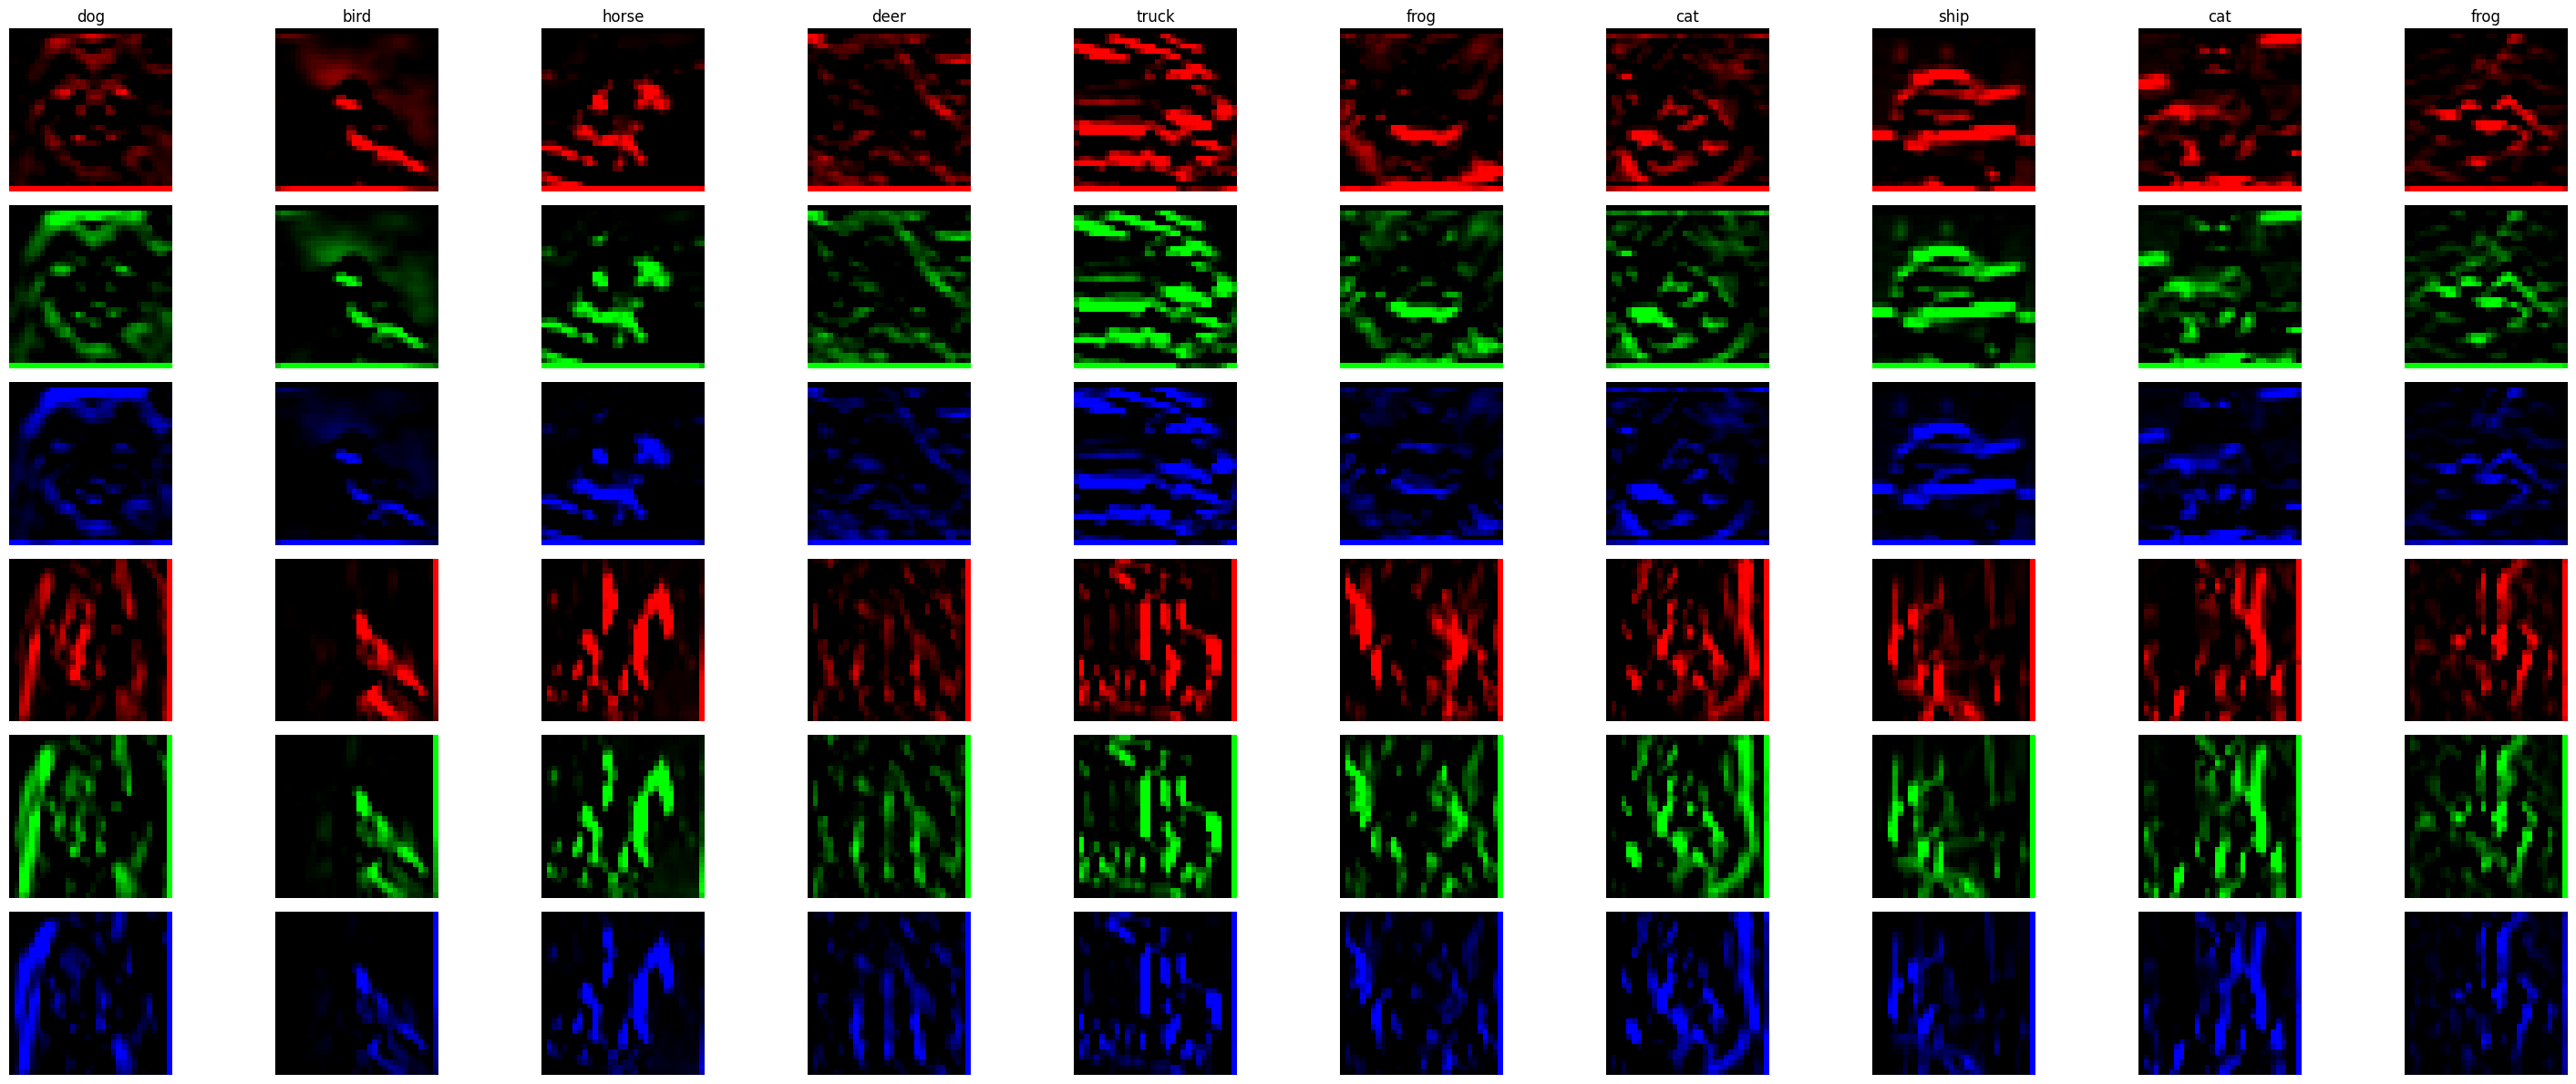

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Randomly choose 10 images from the dataset
indices = np.random.choice(range(len(cifar10)), 10, replace=False)
random_images = [cifar10[i][0] for i in indices]
random_labels = [cifar10[i][1] for i in indices]

# Define channel names and colors
channels = ['R Horizontal', 'G Horizontal', 'B Horizontal', 'R Vertical', 'G Vertical', 'B Vertical']
colors = [(1, 0, 0), (0, 1, 0), (0, 0, 1)] * 2  # RGB colors for horizontal then vertical

# Plot the images with their labels
plt.figure(figsize=(30, 12))
for idx, (image, label) in enumerate(zip(random_images, random_labels)):
    for ch in range(6):
        plt.subplot(6, 10, ch * 10 + idx + 1)

        # Create an empty RGB image
        edge_image_rgb = np.zeros((32, 32, 3))
        edge_image_rgb[..., ch % 3] = image[ch].numpy()  # Set the respective channel

        # Multiply with color
        edge_image_rgb *= np.array(colors[ch])

        # Clip values to valid range
        edge_image_rgb = np.clip(edge_image_rgb, 0, 1)

        plt.imshow(edge_image_rgb)
        if idx == 0:
            plt.ylabel(channels[ch], fontsize=14)
        if ch == 0:
            plt.title(class_names[label])
        plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
# Convolutional neural nets
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()

        # Convolutional Layer 1
        self.conv1 = nn.Conv2d(in_channels=6, out_channels=32, kernel_size=3, padding=1)

        # Convolutional Layer 2
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)

        # Convolutional Layer 3
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)

        # Max Pooling Layer (used after every convolutional layer to reduce spatial dimensions)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Fully Connected Layer
        self.fc1 = nn.Linear(128 * 4 * 4, 512)  # The spatial size reduces to 4x4 after 3 pooling layers
        self.fc2 = nn.Linear(512, 10)

        # Dropout layers with 20% dropout rate for regularization
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.2)

    def forward(self, x):
        # Conv -> LeakyReLU -> Pool
        x = self.pool(F.leaky_relu(self.conv1(x)))
        x = self.dropout1(x)

        x = self.pool(F.leaky_relu(self.conv2(x)))
        x = self.dropout1(x)

        x = self.pool(F.leaky_relu(self.conv3(x)))
        x = self.dropout2(x)

        # Flatten the tensor
        x = x.view(-1, 128 * 4 * 4)

        # Fully Connected Layers
        x = F.leaky_relu(self.fc1(x))
        x = self.fc2(x)

        return x


Epoch 1, Train Loss: 1.9980, Train Accuracy: 0.2604, Validation Loss: 1.6742, Validation Accuracy: 0.3854
Epoch 2, Train Loss: 1.5970, Train Accuracy: 0.4258, Validation Loss: 1.4715, Validation Accuracy: 0.4741
Epoch 3, Train Loss: 1.3740, Train Accuracy: 0.5169, Validation Loss: 1.2798, Validation Accuracy: 0.5427
Epoch 4, Train Loss: 1.2143, Train Accuracy: 0.5734, Validation Loss: 1.1232, Validation Accuracy: 0.6010
Epoch 5, Train Loss: 1.0881, Train Accuracy: 0.6169, Validation Loss: 1.0541, Validation Accuracy: 0.6282
Epoch 6, Train Loss: 0.9952, Train Accuracy: 0.6504, Validation Loss: 0.9430, Validation Accuracy: 0.6687
Epoch 7, Train Loss: 0.9206, Train Accuracy: 0.6794, Validation Loss: 0.8970, Validation Accuracy: 0.6884
Epoch 8, Train Loss: 0.8529, Train Accuracy: 0.7035, Validation Loss: 0.8271, Validation Accuracy: 0.7122
Epoch 9, Train Loss: 0.7980, Train Accuracy: 0.7216, Validation Loss: 0.7987, Validation Accuracy: 0.7173
Epoch 10, Train Loss: 0.7471, Train Accuracy: 

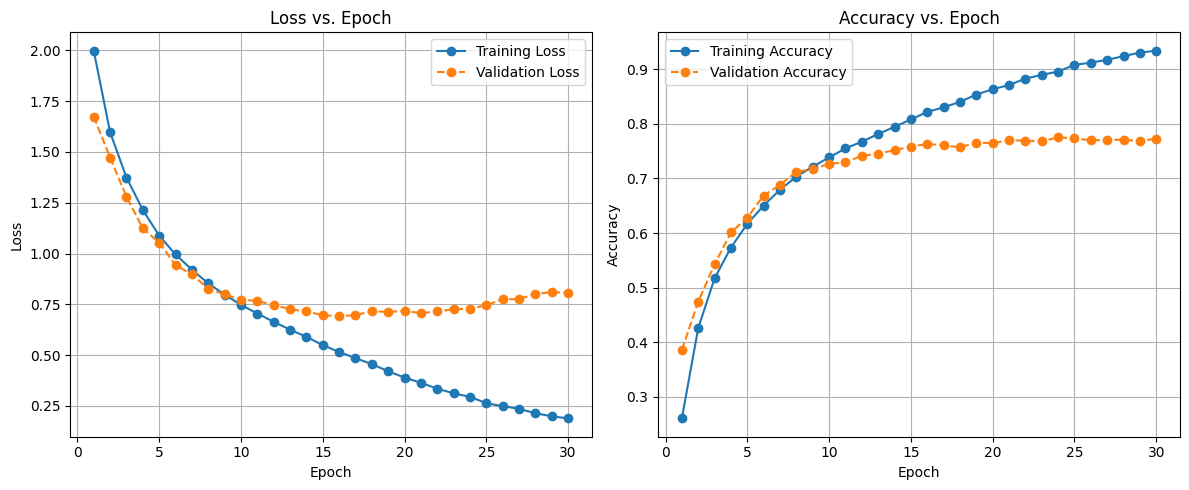

In [ ]:

# Training and validation loop
for epoch in range(1, 31):
    start_time = time.time()

    train_loss, train_accuracy = train(model, train_loader, criterion, optimizer, device)
    valid_loss, valid_accuracy = validate(model, valid_loader, criterion, device)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accuracies.append(train_accuracy.cpu().numpy())
    valid_accuracies.append(valid_accuracy.cpu().numpy())

    total_time += time.time() - start_time

    print(f"Epoch {epoch}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Validation Loss: {valid_loss:.4f}, Validation Accuracy: {valid_accuracy:.4f}")

    total_epochs += 1

# Print total training time
print(f"Total training time: {total_time:.2f} seconds")

# Plotting
plt.figure(figsize=(12, 5))

# Loss plots
plt.subplot(1, 2, 1)
plt.plot(range(1, total_epochs+1), train_losses, marker='o', label='Training Loss')
plt.plot(range(1, total_epochs+1), valid_losses, marker='o', label='Validation Loss', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch')
plt.legend()
plt.grid(True)

# Accuracy plots
plt.subplot(1, 2, 2)
plt.plot(range(1, total_epochs+1), train_accuracies, marker='o', label='Training Accuracy')
plt.plot(range(1, total_epochs+1), valid_accuracies, marker='o', label='Validation Accuracy', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epoch')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
# Create filters for edge detection
horizontal_filter = torch.tensor([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], dtype=torch.float32).unsqueeze(0).unsqueeze(0)
vertical_filter = torch.tensor([[1, 0, -1], [2, 0, -2], [1, 0, -1]], dtype=torch.float32).unsqueeze(0).unsqueeze(0)
inclined_45_filter = torch.tensor([[2, 1, 0], [1, 0, -1], [0, -1, -2]], dtype=torch.float32).unsqueeze(0).unsqueeze(0)
inclined_135_filter = torch.tensor([[0, 1, 2], [-1, 0, 1], [-2, -1, 0]], dtype=torch.float32).unsqueeze(0).unsqueeze(0)

class EdgeDetectionCIFAR10(datasets.CIFAR10):
    def __getitem__(self, index):
        # Get the original image and label
        img, label = super(EdgeDetectionCIFAR10, self).__getitem__(index)

        # Convert the image to a batch of 1 to use with conv2d
        img_batch = img.unsqueeze(0)

        # Apply the filters
        img_horizontal = F.conv2d(img_batch, horizontal_filter, padding=1)
        img_vertical = F.conv2d(img_batch, vertical_filter, padding=1)
        img_inclined_45 = F.conv2d(img_batch, inclined_45_filter, padding=1)
        img_inclined_135 = F.conv2d(img_batch, inclined_135_filter, padding=1)

        # Concatenate the results
        processed_img = torch.cat([img_horizontal, img_vertical, img_inclined_45, img_inclined_135], dim=1).squeeze(0)

        return processed_img, label

# Define your transform
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert RGB to Grayscale
    transforms.ToTensor()  # Convert the image to a tensor
])

# Load the CIFAR10 dataset with edge detection
cifar10 = EdgeDetectionCIFAR10(root='./data', train=True, download=True, transform=transform)

# Define the CIFAR10 class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']





Files already downloaded and verified


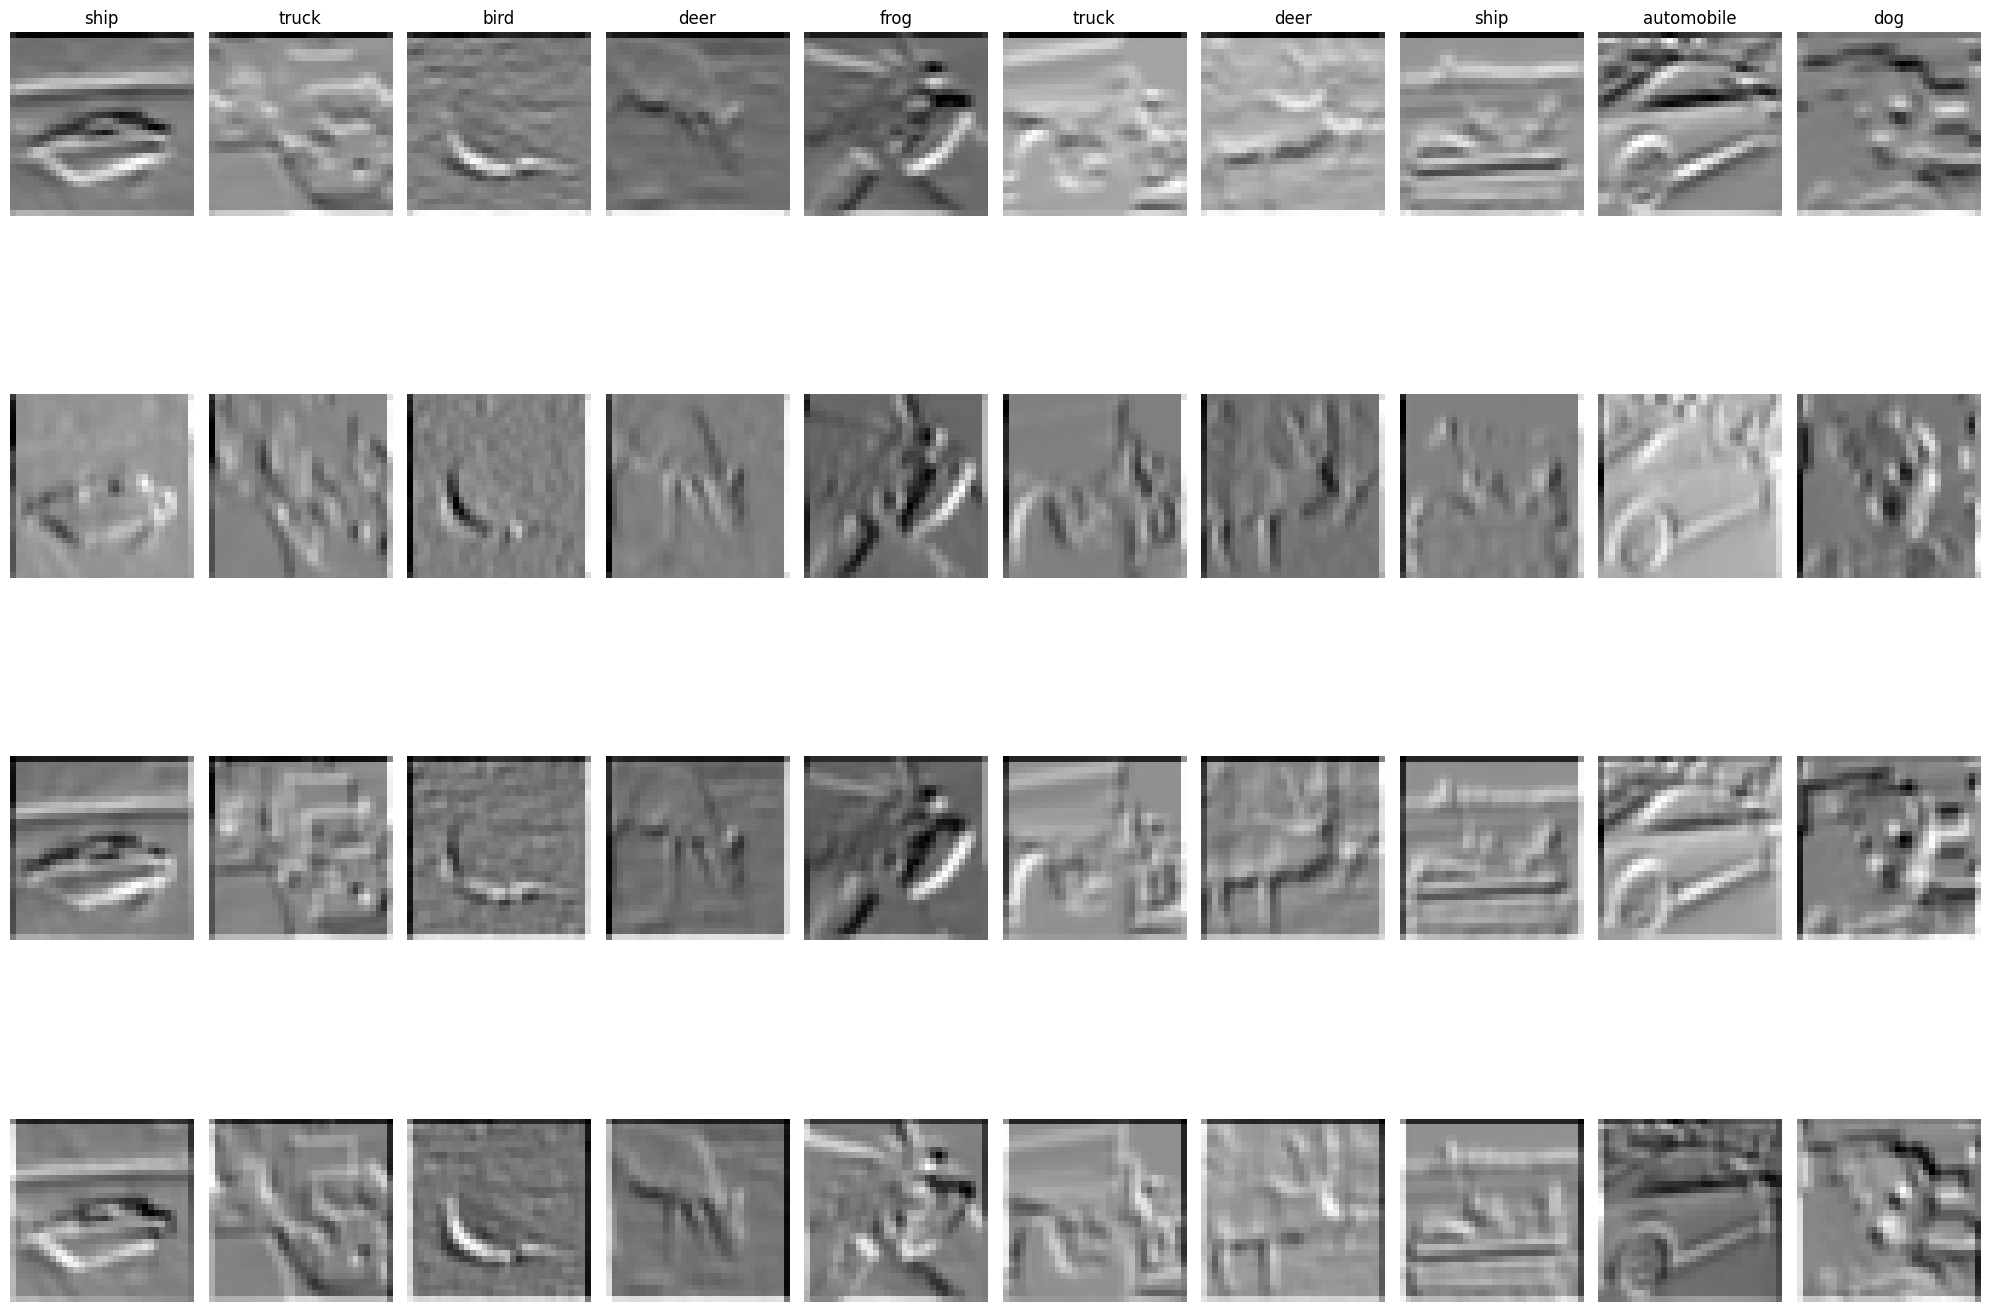

In [ ]:
# Randomly choose 10 images from the dataset
indices = np.random.choice(range(len(cifar10)), 10, replace=False)
random_images = [cifar10[i][0] for i in indices]
random_labels = [cifar10[i][1] for i in indices]

# Plot the images with their labels
plt.figure(figsize=(20, 16))

for idx, (image, label) in enumerate(zip(random_images, random_labels)):

    # Display horizontal edges
    plt.subplot(4, 10, idx + 1)
    horizontal_image = image[0].numpy()  # Extract the horizontal channel
    plt.imshow(horizontal_image, cmap='gray')
    if idx == 0:
        plt.ylabel("Horizontal", fontsize=14)
    plt.title(class_names[label])
    plt.axis('off')

    # Display vertical edges
    plt.subplot(4, 10, idx + 11)  # Offset by 10 for the second row
    vertical_image = image[1].numpy()  # Extract the vertical channel
    plt.imshow(vertical_image, cmap='gray')
    if idx == 0:
        plt.ylabel("Vertical", fontsize=14)
    plt.axis('off')

    # Display 45-degree inclined edges
    plt.subplot(4, 10, idx + 21)  # Offset by 20 for the third row
    inclined_45_image = image[2].numpy()  # Extract the 45-degree inclined channel
    plt.imshow(inclined_45_image, cmap='gray')
    if idx == 0:
        plt.ylabel("45-degree", fontsize=14)
    plt.axis('off')

    # Display 135-degree inclined edges
    plt.subplot(4, 10, idx + 31)  # Offset by 30 for the fourth row
    inclined_135_image = image[3].numpy()  # Extract the 135-degree inclined channel
    plt.imshow(inclined_135_image, cmap='gray')
    if idx == 0:
        plt.ylabel("135-degree", fontsize=14)
    plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
# Convolutional neural nets
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()

        # Convolutional Layer 1
        self.conv1 = nn.Conv2d(in_channels=4, out_channels=32, kernel_size=3, padding=1)

        # Convolutional Layer 2
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)

        # Convolutional Layer 3
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)

        # Max Pooling Layer (used after every convolutional layer to reduce spatial dimensions)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Fully Connected Layer
        self.fc1 = nn.Linear(128 * 4 * 4, 512)  # The spatial size reduces to 4x4 after 3 pooling layers
        self.fc2 = nn.Linear(512, 10)

        # Dropout layers with 20% dropout rate for regularization
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.2)

    def forward(self, x):
        # Conv -> LeakyReLU -> Pool
        x = self.pool(F.leaky_relu(self.conv1(x)))
        x = self.dropout1(x)

        x = self.pool(F.leaky_relu(self.conv2(x)))
        x = self.dropout1(x)

        x = self.pool(F.leaky_relu(self.conv3(x)))
        x = self.dropout2(x)

        # Flatten the tensor
        x = x.view(-1, 128 * 4 * 4)

        # Fully Connected Layers
        x = F.leaky_relu(self.fc1(x))
        x = self.fc2(x)

        return x


Epoch 1, Train Loss: 2.0165, Train Accuracy: 0.2559, Validation Loss: 1.6963, Validation Accuracy: 0.3861
Epoch 2, Train Loss: 1.6054, Train Accuracy: 0.4289, Validation Loss: 1.4261, Validation Accuracy: 0.5084
Epoch 3, Train Loss: 1.3825, Train Accuracy: 0.5169, Validation Loss: 1.2412, Validation Accuracy: 0.5714
Epoch 4, Train Loss: 1.2201, Train Accuracy: 0.5749, Validation Loss: 1.1527, Validation Accuracy: 0.6043
Epoch 5, Train Loss: 1.1030, Train Accuracy: 0.6172, Validation Loss: 1.0247, Validation Accuracy: 0.6467
Epoch 6, Train Loss: 1.0120, Train Accuracy: 0.6497, Validation Loss: 0.9424, Validation Accuracy: 0.6757
Epoch 7, Train Loss: 0.9393, Train Accuracy: 0.6747, Validation Loss: 0.9345, Validation Accuracy: 0.6768
Epoch 8, Train Loss: 0.8818, Train Accuracy: 0.6959, Validation Loss: 0.8687, Validation Accuracy: 0.7048
Epoch 9, Train Loss: 0.8255, Train Accuracy: 0.7145, Validation Loss: 0.8595, Validation Accuracy: 0.7012
Epoch 10, Train Loss: 0.7780, Train Accuracy: 

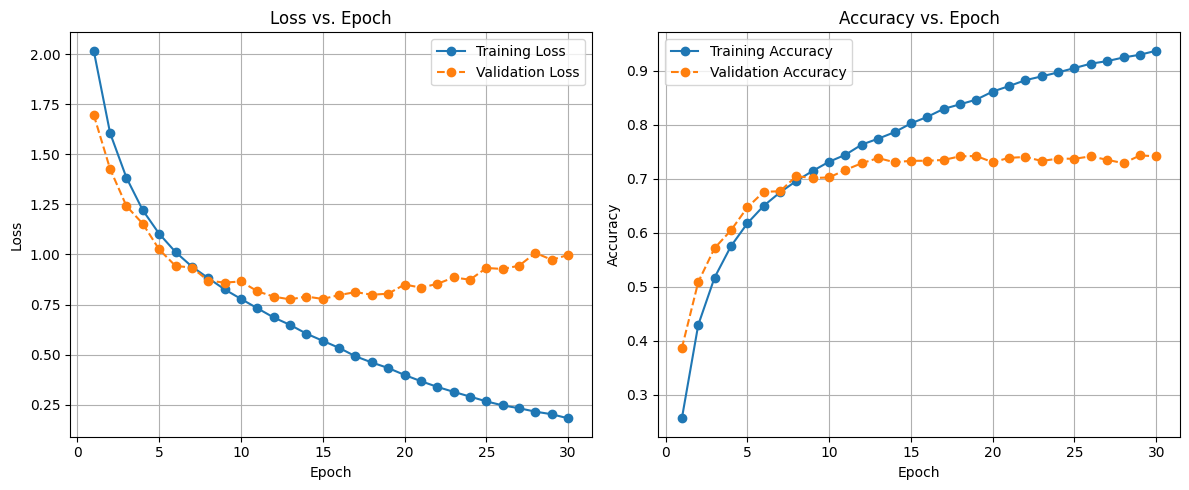

In [ ]:

# Training and validation loop
for epoch in range(1, 31):
    start_time = time.time()

    train_loss, train_accuracy = train(model, train_loader, criterion, optimizer, device)
    valid_loss, valid_accuracy = validate(model, valid_loader, criterion, device)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accuracies.append(train_accuracy.cpu().numpy())
    valid_accuracies.append(valid_accuracy.cpu().numpy())

    total_time += time.time() - start_time

    print(f"Epoch {epoch}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Validation Loss: {valid_loss:.4f}, Validation Accuracy: {valid_accuracy:.4f}")

    total_epochs += 1

# Print total training time
print(f"Total training time: {total_time:.2f} seconds")

# Plotting
plt.figure(figsize=(12, 5))

# Loss plots
plt.subplot(1, 2, 1)
plt.plot(range(1, total_epochs+1), train_losses, marker='o', label='Training Loss')
plt.plot(range(1, total_epochs+1), valid_losses, marker='o', label='Validation Loss', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch')
plt.legend()
plt.grid(True)

# Accuracy plots
plt.subplot(1, 2, 2)
plt.plot(range(1, total_epochs+1), train_accuracies, marker='o', label='Training Accuracy')
plt.plot(range(1, total_epochs+1), valid_accuracies, marker='o', label='Validation Accuracy', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epoch')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
#Fully connected feedforward Model
#Leaky Relu for hidden layers and softmax for outter layer
#with dropout layers to reduce overfitting
#with L2 regulization

class MLPModel_5(nn.Module):
    def __init__(self):
        super(MLPModel_5, self).__init__()
        self.fc1 = nn.Linear(32*32*4, 512)   # First hidden layer with 1024 neurons
        self.fc2 = nn.Linear(512, 256)        # Third hidden layer with 256 neurons
        self.fc3 = nn.Linear(256, 10)         # Output layer with 10 neurons (for 10 classes)

        # Dropout layers with 15% dropout rate for regularization
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.25)

    def forward(self, x):
        x = x.view(x.size(0), -1)             # Flatten the input
        x = F.leaky_relu(self.fc1(x))          # Leaky ReLU activation
        x = self.dropout1(x)
        x = F.leaky_relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x


Epoch 1, Train Loss: 2.0802, Train Accuracy: 0.2469, Validation Loss: 1.9774, Validation Accuracy: 0.2913
Epoch 2, Train Loss: 1.8898, Train Accuracy: 0.3279, Validation Loss: 1.8070, Validation Accuracy: 0.3598
Epoch 3, Train Loss: 1.7712, Train Accuracy: 0.3694, Validation Loss: 1.7206, Validation Accuracy: 0.3902
Epoch 4, Train Loss: 1.6815, Train Accuracy: 0.3990, Validation Loss: 1.6685, Validation Accuracy: 0.4014
Epoch 5, Train Loss: 1.6094, Train Accuracy: 0.4263, Validation Loss: 1.6394, Validation Accuracy: 0.4184
Epoch 6, Train Loss: 1.5511, Train Accuracy: 0.4502, Validation Loss: 1.6157, Validation Accuracy: 0.4221
Epoch 7, Train Loss: 1.4912, Train Accuracy: 0.4692, Validation Loss: 1.5925, Validation Accuracy: 0.4325
Epoch 8, Train Loss: 1.4327, Train Accuracy: 0.4908, Validation Loss: 1.6057, Validation Accuracy: 0.4291
Epoch 9, Train Loss: 1.3880, Train Accuracy: 0.5049, Validation Loss: 1.6133, Validation Accuracy: 0.4280
Epoch 10, Train Loss: 1.3437, Train Accuracy: 

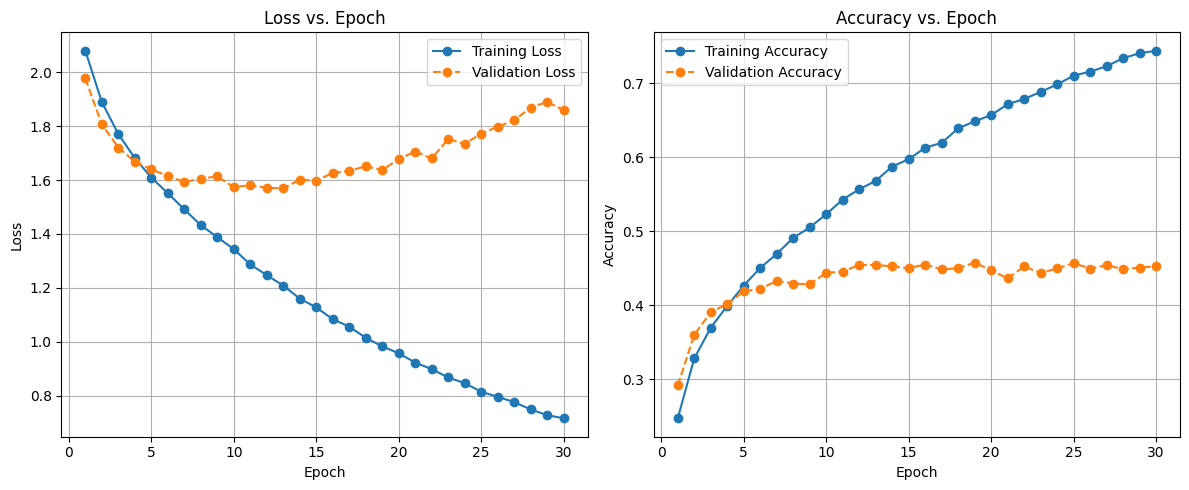

In [ ]:

# Training and validation loop
for epoch in range(1, 31):
    start_time = time.time()

    train_loss, train_accuracy = train(model, train_loader, criterion, optimizer, device)
    valid_loss, valid_accuracy = validate(model, valid_loader, criterion, device)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accuracies.append(train_accuracy.cpu().numpy())
    valid_accuracies.append(valid_accuracy.cpu().numpy())

    total_time += time.time() - start_time

    print(f"Epoch {epoch}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Validation Loss: {valid_loss:.4f}, Validation Accuracy: {valid_accuracy:.4f}")

    total_epochs += 1

# Print total training time
print(f"Total training time: {total_time:.2f} seconds")

# Plotting
plt.figure(figsize=(12, 5))

# Loss plots
plt.subplot(1, 2, 1)
plt.plot(range(1, total_epochs+1), train_losses, marker='o', label='Training Loss')
plt.plot(range(1, total_epochs+1), valid_losses, marker='o', label='Validation Loss', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch')
plt.legend()
plt.grid(True)

# Accuracy plots
plt.subplot(1, 2, 2)
plt.plot(range(1, total_epochs+1), train_accuracies, marker='o', label='Training Accuracy')
plt.plot(range(1, total_epochs+1), valid_accuracies, marker='o', label='Validation Accuracy', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epoch')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
class VerticalHorizontalChangeCIFAR10(datasets.CIFAR10):
    def __getitem__(self, index):
        # Get the original grayscale image and label
        original_img, label = super(VerticalHorizontalChangeCIFAR10, self).__getitem__(index)

        # Vertical difference: Calculate the absolute difference between each pixel and the one below it
        vertical_diff = torch.abs(original_img[:, :-1, :] - original_img[:, 1:, :])

        # Horizontal difference: Calculate the absolute difference between each pixel and the one to its right
        horizontal_diff = torch.abs(original_img[:, :, :-1] - original_img[:, :, 1:])

        # Pad the bottom row and rightmost column with zeros to maintain the original size
        vertical_padding_shape = (original_img.shape[0], 1, original_img.shape[2])  # This will be (1, 1, 32) for grayscale images
        horizontal_padding_shape = (original_img.shape[0], original_img.shape[1], 1) # This will be (1, 32, 1) for grayscale images

        padded_vertical_diff = torch.cat([vertical_diff, torch.zeros(vertical_padding_shape)], dim=1)
        padded_horizontal_diff = torch.cat([horizontal_diff, torch.zeros(horizontal_padding_shape)], dim=2)

        # Concatenate along the channel dimension to produce (2, 32, 32)
        combined_diff = torch.cat([padded_vertical_diff, padded_horizontal_diff], dim=0)

        return combined_diff, label

# Transform
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

# Load the modified CIFAR10 dataset
cifar10 = VerticalHorizontalChangeCIFAR10(root='./data', train=True, download=True, transform=transform)

# Define the CIFAR10 class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Files already downloaded and verified


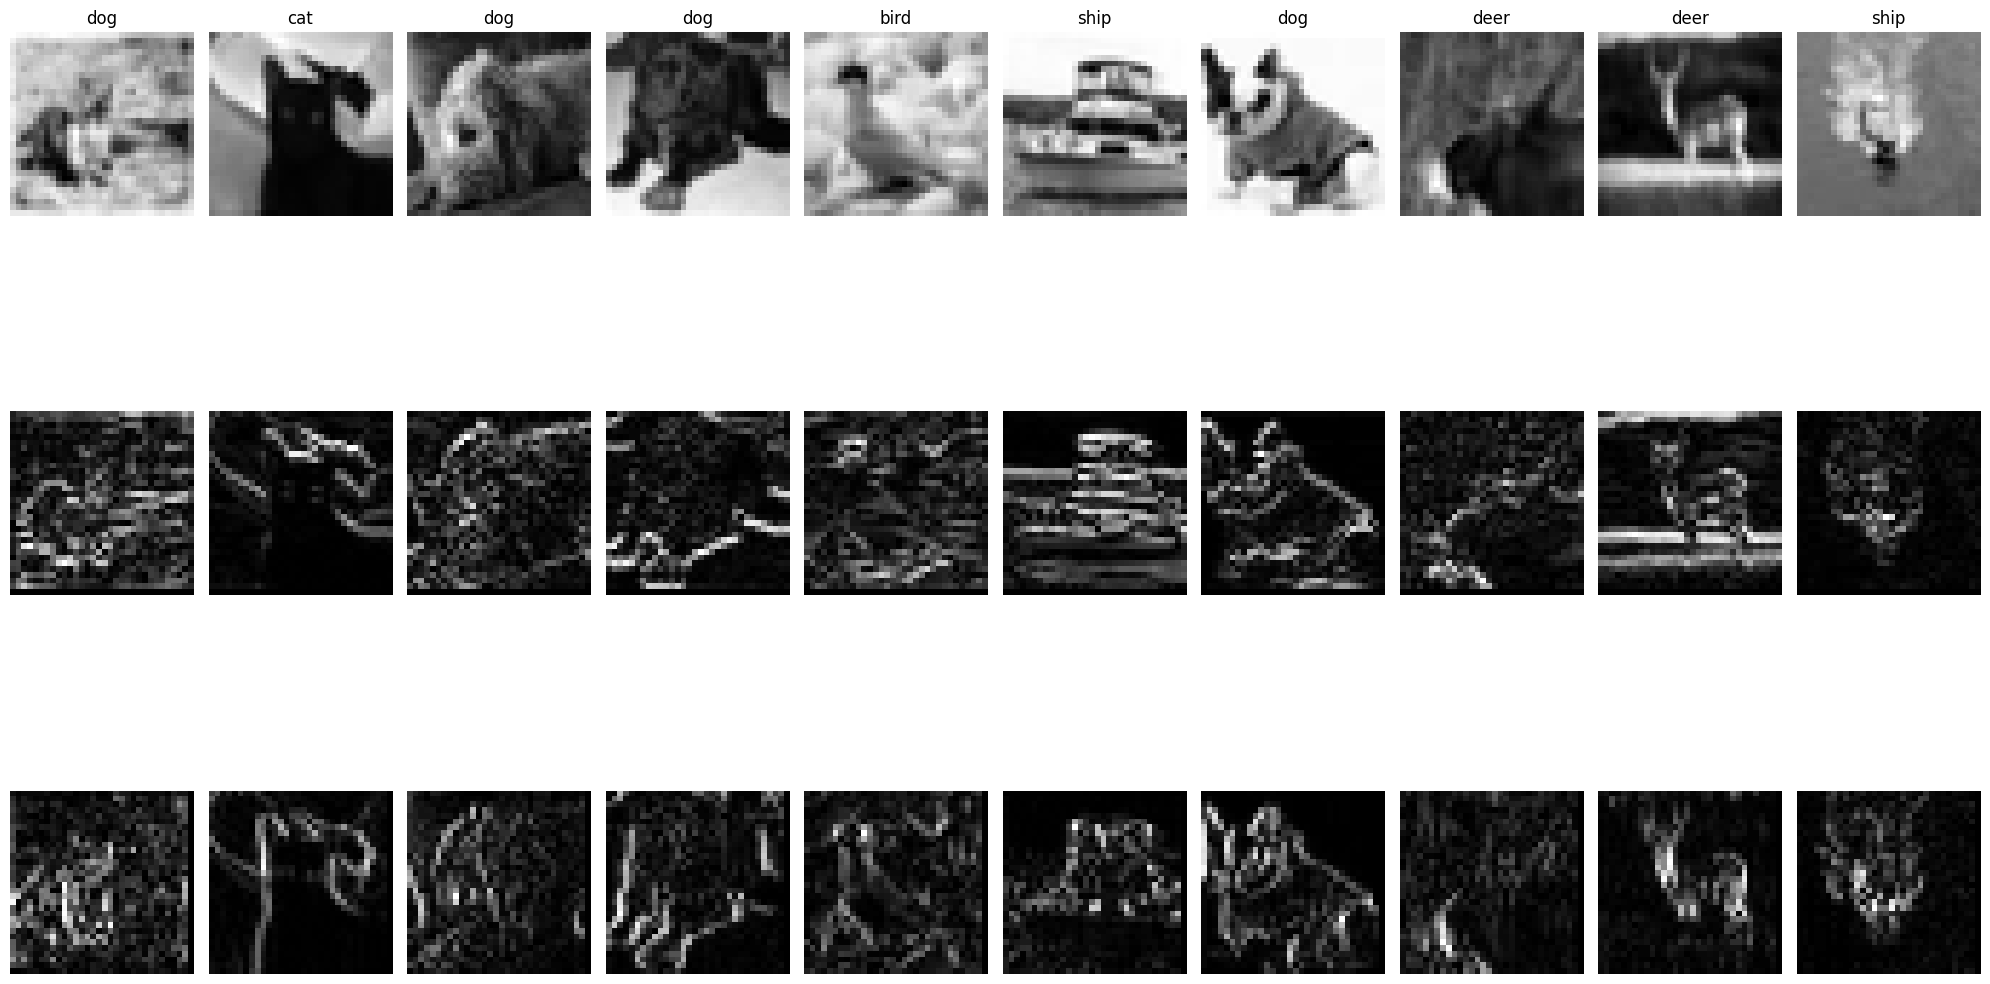

In [ ]:
# Randomly choose 10 images from the dataset
indices = np.random.choice(range(len(cifar10)), 10, replace=False)
random_images = [cifar10[i] for i in indices]  # This fetches the tuples (original_img, combined_diff, label)

# Plot the images with their labels
plt.figure(figsize=(20, 16))

for idx, (original, combined_diff, label) in enumerate(random_images):

    # Display the grayscale image
    plt.subplot(4, 10, idx + 1)
    plt.imshow(original[0].numpy(), cmap='gray')  # Extracting the grayscale channel
    if idx == 0:
        plt.ylabel("Grayscale", fontsize=14)
    plt.title(class_names[label])
    plt.axis('off')

    # Display the vertical color change image
    plt.subplot(4, 10, idx + 11)
    plt.imshow(combined_diff[0].numpy(), cmap='gray')  # Extracting the vertical change channel
    if idx == 0:
        plt.ylabel("Vertical Change", fontsize=14)
    plt.axis('off')

    # Display the horizontal color change image
    plt.subplot(4, 10, idx + 21)
    plt.imshow(combined_diff[1].numpy(), cmap='gray')  # Extracting the horizontal change channel
    if idx == 0:
        plt.ylabel("Horizontal Change", fontsize=14)
    plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
# Convolutional neural nets
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()

        # Convolutional Layer 1
        self.conv1 = nn.Conv2d(in_channels=2, out_channels=32, kernel_size=3, padding=1)

        # Convolutional Layer 2
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)

        # Convolutional Layer 3
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)

        # Max Pooling Layer (used after every convolutional layer to reduce spatial dimensions)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Fully Connected Layer
        self.fc1 = nn.Linear(128 * 4 * 4, 512)  # The spatial size reduces to 4x4 after 3 pooling layers
        self.fc2 = nn.Linear(512, 10)

        # Dropout layers with 20% dropout rate for regularization
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.2)

    def forward(self, x):
        # Conv -> LeakyReLU -> Pool
        x = self.pool(F.leaky_relu(self.conv1(x)))
        x = self.dropout1(x)

        x = self.pool(F.leaky_relu(self.conv2(x)))
        x = self.dropout1(x)

        x = self.pool(F.leaky_relu(self.conv3(x)))
        x = self.dropout2(x)

        # Flatten the tensor
        x = x.view(-1, 128 * 4 * 4)

        # Fully Connected Layers
        x = F.leaky_relu(self.fc1(x))
        x = self.fc2(x)

        return x


Epoch 1, Train Loss: 2.2989, Train Accuracy: 0.1115, Validation Loss: 2.2901, Validation Accuracy: 0.1699
Epoch 2, Train Loss: 2.1592, Train Accuracy: 0.2046, Validation Loss: 1.9384, Validation Accuracy: 0.2911
Epoch 3, Train Loss: 1.8937, Train Accuracy: 0.3050, Validation Loss: 1.8324, Validation Accuracy: 0.3325
Epoch 4, Train Loss: 1.7447, Train Accuracy: 0.3729, Validation Loss: 1.6289, Validation Accuracy: 0.4298
Epoch 5, Train Loss: 1.6128, Train Accuracy: 0.4318, Validation Loss: 1.5398, Validation Accuracy: 0.4619
Epoch 6, Train Loss: 1.5092, Train Accuracy: 0.4711, Validation Loss: 1.4308, Validation Accuracy: 0.4991
Epoch 7, Train Loss: 1.4270, Train Accuracy: 0.5021, Validation Loss: 1.3763, Validation Accuracy: 0.5218
Epoch 8, Train Loss: 1.3608, Train Accuracy: 0.5275, Validation Loss: 1.3067, Validation Accuracy: 0.5410
Epoch 9, Train Loss: 1.3027, Train Accuracy: 0.5485, Validation Loss: 1.2717, Validation Accuracy: 0.5624
Epoch 10, Train Loss: 1.2512, Train Accuracy: 

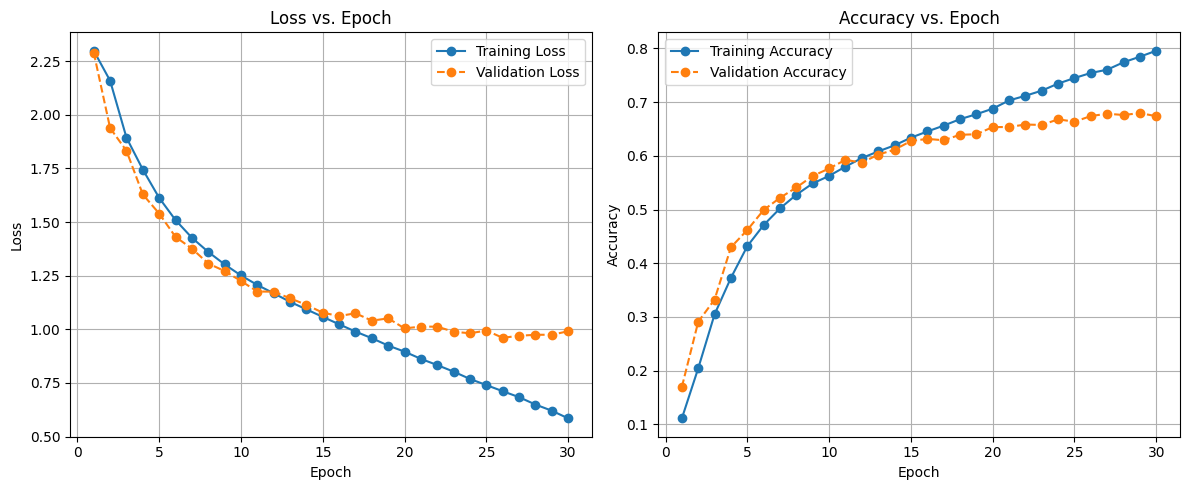

In [ ]:

# Training and validation loop
for epoch in range(1, 31):
    start_time = time.time()

    train_loss, train_accuracy = train(model, train_loader, criterion, optimizer, device)
    valid_loss, valid_accuracy = validate(model, valid_loader, criterion, device)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accuracies.append(train_accuracy.cpu().numpy())
    valid_accuracies.append(valid_accuracy.cpu().numpy())

    total_time += time.time() - start_time

    print(f"Epoch {epoch}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Validation Loss: {valid_loss:.4f}, Validation Accuracy: {valid_accuracy:.4f}")

    total_epochs += 1

# Print total training time
print(f"Total training time: {total_time:.2f} seconds")

# Plotting
plt.figure(figsize=(12, 5))

# Loss plots
plt.subplot(1, 2, 1)
plt.plot(range(1, total_epochs+1), train_losses, marker='o', label='Training Loss')
plt.plot(range(1, total_epochs+1), valid_losses, marker='o', label='Validation Loss', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch')
plt.legend()
plt.grid(True)

# Accuracy plots
plt.subplot(1, 2, 2)
plt.plot(range(1, total_epochs+1), train_accuracies, marker='o', label='Training Accuracy')
plt.plot(range(1, total_epochs+1), valid_accuracies, marker='o', label='Validation Accuracy', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epoch')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
#Benchmark Model
#Singal layer fully connected
class BenchmarkModel(nn.Module):
    def __init__(self):
        super(BenchmarkModel, self).__init__()
        self.fc = nn.Linear(32*32*2, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

Epoch 1, Train Loss: 2.1698, Train Accuracy: 0.2709, Validation Loss: 2.0705, Validation Accuracy: 0.3452
Epoch 2, Train Loss: 2.0044, Train Accuracy: 0.3643, Validation Loss: 1.9549, Validation Accuracy: 0.3660
Epoch 3, Train Loss: 1.9120, Train Accuracy: 0.3854, Validation Loss: 1.8867, Validation Accuracy: 0.3837
Epoch 4, Train Loss: 1.8521, Train Accuracy: 0.3949, Validation Loss: 1.8403, Validation Accuracy: 0.3971
Epoch 5, Train Loss: 1.8097, Train Accuracy: 0.4068, Validation Loss: 1.8061, Validation Accuracy: 0.3948
Epoch 6, Train Loss: 1.7774, Train Accuracy: 0.4122, Validation Loss: 1.7794, Validation Accuracy: 0.4030
Epoch 7, Train Loss: 1.7521, Train Accuracy: 0.4175, Validation Loss: 1.7588, Validation Accuracy: 0.4080
Epoch 8, Train Loss: 1.7313, Train Accuracy: 0.4219, Validation Loss: 1.7432, Validation Accuracy: 0.4086
Epoch 9, Train Loss: 1.7137, Train Accuracy: 0.4269, Validation Loss: 1.7298, Validation Accuracy: 0.4104
Epoch 10, Train Loss: 1.6991, Train Accuracy: 

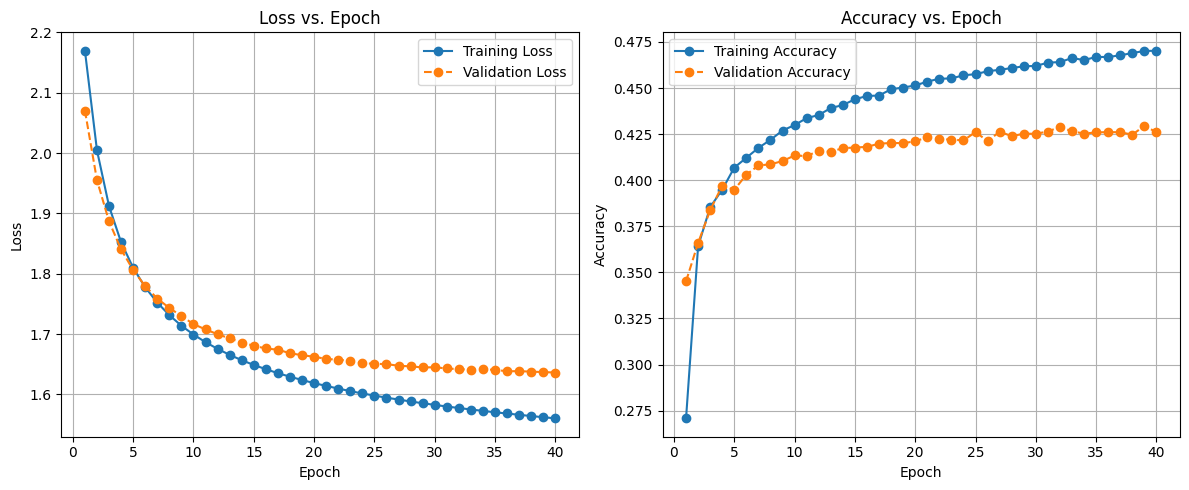

In [ ]:
# Training and validation loop
for epoch in range(1, 41):
    start_time = time.time()

    train_loss, train_accuracy = train(model, train_loader, criterion, optimizer, device)
    valid_loss, valid_accuracy = validate(model, valid_loader, criterion, device)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accuracies.append(train_accuracy.cpu().numpy())
    valid_accuracies.append(valid_accuracy.cpu().numpy())

    total_time += time.time() - start_time

    print(f"Epoch {epoch}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Validation Loss: {valid_loss:.4f}, Validation Accuracy: {valid_accuracy:.4f}")

    total_epochs += 1

# Print total training time
print(f"Total training time: {total_time:.2f} seconds")

# Plotting
plt.figure(figsize=(12, 5))

# Loss plots
plt.subplot(1, 2, 1)
plt.plot(range(1, total_epochs+1), train_losses, marker='o', label='Training Loss')
plt.plot(range(1, total_epochs+1), valid_losses, marker='o', label='Validation Loss', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch')
plt.legend()
plt.grid(True)

# Accuracy plots
plt.subplot(1, 2, 2)
plt.plot(range(1, total_epochs+1), train_accuracies, marker='o', label='Training Accuracy')
plt.plot(range(1, total_epochs+1), valid_accuracies, marker='o', label='Validation Accuracy', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epoch')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
